<h1>Who will make it to the end? </h1>


<b>Machine Learning project - Mattia Moro</b>

"Ultra Trail Du Mont Blanc" is the quintessential Trail running and Ultra running race all around the world, and all the best athletes of these sports had took part in it, attempting to break records during every single edition. This race is noticeable also from a statistical point of view, because of the high number of participants and of its huge complexity and variability. These factors make roughly hard to foresee whether a runner will be able to cross the finish line or not, even for the elites.
The question is, <i>can a Machine Learning model succeed in predicting who will cross this finish line? </i>

An answer will tried to be provided in this project

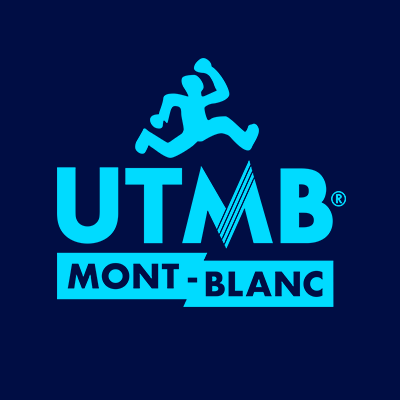

<h2>Preliminary examination</h2>
<bf>
This section is thought to give some necessary premixes, briefly explaining what the race consists in, where the datas were taken and the goals to expect.

### UTMB

The race in question consists in a ring course around the Mont Blanc massif, starting and finishing in Chamonix,passing in 3 countries and completing a 170km with 10000 m d+/- track. For its fame, runners from every country try to participate in it, but the number of starters is fixed around 2500, which is already a really huge number for trail running races, which for security reasons can face also more restriction on the participant list. 
Perhaps the most interesting part is that the extreme lenght of the course increases really the variability of performances for everyone.
Usually the best runners make it in 20-24 hrs, however most of participants take among 40 hrs to complete the course,with a limit of 46.

### Dataset

Despite the 2022 edition was place of a shocking a course record, with the Spanish athlete Kilian Jornet to brake the 20 hours wall with a time of 19:49:35, there weren't enough datas to be examined of it.
The dataset will regard the 2015 edition. In particular, the raw data were taken from the <a href="https://github.com/ricfog/TRAP-data">github</a> of the "TRAP" project, and consist in:
- The official classification of this edition;
- Further informations about the runners provided by the ITRA.

The second source consist in a rich list of athletes informations stored in the site of the International Trail Running Association, scraped and transformed in raw data for the "TRAP" framework (to be precise, the raw data was the only part of the project taken from this source). 
As this is only a breif introduction, a detailed explanation of the dataset will be provided in the dedicated section. For now we can benefit from a pic of the GOAT crossing the arrival in 2022, before discussing the goals


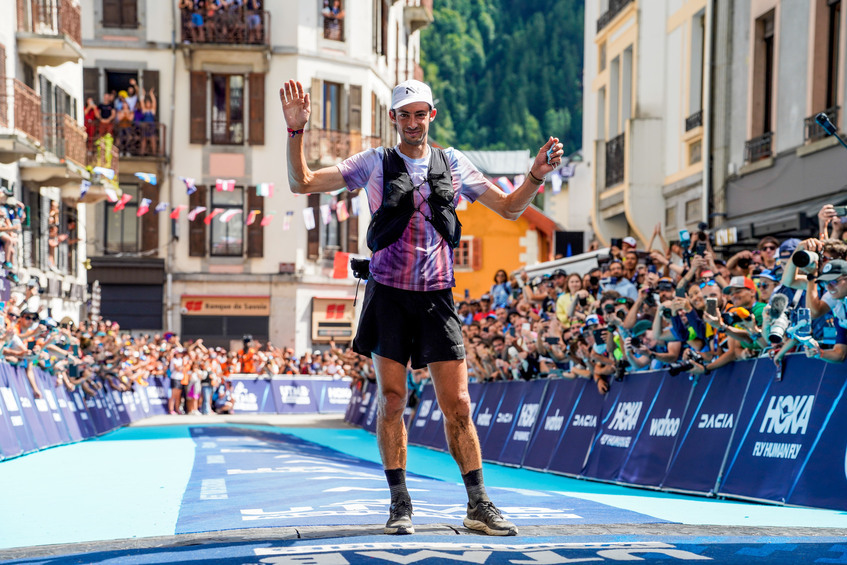

### Goals

A doverous premise is that, even thought the dataset can possibly seem to be poor, is in reality quite great talking about this context, in which usually the races are considered to be 'big' even if 500 participants are reached. Taking this into account, the number of samples used can be acceptable both for ML and trail running purposes.
Moving to the main part, this project has two goals:
- predict wheter a runner will or will not finish the race, with a <b>binary classification</b>;
- a further prediction of the time taken to finish the race , with a <b>regressor</b>.

<i>(import all necessary libraries)</i>

In [23]:
pip install pip --upgrade

Note: you may need to restart the kernel to use updated packages.


In [24]:
!pip install imblearn
!pip install xgboost
!pip install missingno
!pip install mlxtend

In [25]:
import pandas as pd
import numpy as np
from random import randrange
import random

import itertools


from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, r2_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from scipy.stats import loguniform, beta, uniform
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

<h2>From raw data to the dataset</h2>
<p>
As mentioned before, the dataset was created by taking two different tables. In particular, each one was precisely manipulated with the "Pandas" library to be suitable for machine learning tasks, then the two tables were merged in a bigger one. This is the general workflow, the precise manipulations are described below.

### Itra table

This first table contains informations about athletes, however it has two main problems:
- The shape isn't usable for the project;
- It can have too little features.
This table has single rows consisting in the registration of a specific race ran by an athlete, with information about:
- the Race itself : <b>key, name of the race, location, date, year, distance, elevation</b>
- the Athlete and its performance: <b>name, sex, nationality, ranking, time, consecutive years at the race</b>.
The main goal now is to have a single row for each athlete, so that this table and the one with UTMB ranking can be merged togheter using the name of the athlete. 
Take a look now to the dataset:

In [26]:
playground3 = pd.read_csv('data/history_matched_2015.csv', error_bad_lines=False, sep=',')
playground3.head()

Unnamed: 0        X  key_race              Name      Time  Ranking  Sex  \
0   2086899.0  2086899     11376  Xavier THEVENARD  04:29:51     18.0  Man   
1   2117125.0  2117125     11551  Xavier THEVENARD  08:41:45      8.0  Man   
2   2171725.0  2171725     11814  Xavier THEVENARD  08:46:00      1.0  Man   
3   2311222.0  2311222     12457  Xavier THEVENARD  14:10:37      1.0  Man   
4   2392448.0  2392448     12859  Xavier THEVENARD  08:49:07      4.0  Man   

  Nationality                                               Race  \
0      France  MARATHON DU MONT-BLANC 2015 - 42 KM DU MONT-BLANC   
1      France  MAXI-RACE DU LAC D'ANNECY 2015 - IAUTWC-TRAIL ...   
2      France                             ULTRA FIORD 2015 - 70K   
3      France             ULTRA-TRAIL DU MONT-BLANC® 2014 - TDS®   
4      France  MAXI-RACE DU LAC D'ANNECY 2014 - TECNICA MAXI-...   

                                       Location        Date  Distance  \
0                    France - 74 - Haute-Savoie  2015-06-28      42.0   
1                    France - 74 - Haute-Savoie  2015-05-30      82.7   
2  Chile - Magallanes y de la Antartica Chilena  2015-04-18      71.2   
3                    France - 74 - Haute-Savoie  2014-08-27     119.1   
4                    France - 74 - Haute-Savoie  2014-05-31      82.8   

   Elevation  Year  until_year  
0       2730  2015        2015  
1       5160  2015        2015  
2       2920  2015        2015  
3       7340  2014        2015  
4       5140  2014        2015


For this purpose the <i>groupby</i> Pandas function is used, thanks which one is able to aggregate different rows togheter in base on a particular value (the name in this case), and is also able to decide what to do with the other 'redundant' records. 
However, before proceeding with it, an important observation has to be done. 
For some datas it is useful to take only one of them in the aggregation (such as nationality or sex), but for others, if we want to take really the maximum amount of informations out, it is not enough to take only one value!
An example can be the <b>ranking</b>, if we take only one ranking value for each athlete there would be a great loss of information. It would be more correct to elaborate our rankings to extract further informations. 
This reasoning can be extended also to <b>time, distance</b> and <b>elevation</b>. In particular, the feature construction involves the adding, for these four informations, of their:

- maximum;
- minimum;
- average;
- sum
For doing this, first we create a duplicate of each column for each information, then perform the aggregation with the right function.

In [27]:
playground3['Time_mean'] = playground3.loc[:, 'Time']
playground3['Time_max'] = playground3.loc[:, 'Time']
playground3['Time_min'] = playground3.loc[:, 'Time']


playground3['Elev_mean'] = playground3.loc[:, 'Elevation']
playground3['Elev_max'] = playground3.loc[:, 'Elevation']
playground3['Elev_min'] = playground3.loc[:, 'Elevation']


playground3['Distance_mean'] = playground3.loc[:, 'Distance']
playground3['Distance_max'] = playground3.loc[:, 'Distance']
playground3['Distance_min'] = playground3.loc[:, 'Distance']


playground3['Rank_mean'] = playground3.loc[:, 'Ranking']
playground3['Rank_max'] = playground3.loc[:, 'Ranking']
playground3['Rank_min'] = playground3.loc[:, 'Ranking']

The 'until_year' column represents how many editions of a race an athlete participated in, so, in order to keep this information, the value in each cell will be replaced by the result of a simple math operation that represents the number of consequent participations.

In [28]:
playground32 = playground3['until_year'].add(1).sub(playground3['Year']).to_frame('participations')

In [29]:
playground32.head()

participations
0               1
1               1
2               1
3               2
4               2

In [30]:
playground3['until_year'] = playground32['participations']

This below is the aspect of the table after the duplication of the selected columns for the aggregation and the transformation of the 'until_year' column.

In [31]:
playground3.head()

Unnamed: 0        X  key_race              Name      Time  Ranking  Sex  \
0   2086899.0  2086899     11376  Xavier THEVENARD  04:29:51     18.0  Man   
1   2117125.0  2117125     11551  Xavier THEVENARD  08:41:45      8.0  Man   
2   2171725.0  2171725     11814  Xavier THEVENARD  08:46:00      1.0  Man   
3   2311222.0  2311222     12457  Xavier THEVENARD  14:10:37      1.0  Man   
4   2392448.0  2392448     12859  Xavier THEVENARD  08:49:07      4.0  Man   

  Nationality                                               Race  \
0      France  MARATHON DU MONT-BLANC 2015 - 42 KM DU MONT-BLANC   
1      France  MAXI-RACE DU LAC D'ANNECY 2015 - IAUTWC-TRAIL ...   
2      France                             ULTRA FIORD 2015 - 70K   
3      France             ULTRA-TRAIL DU MONT-BLANC® 2014 - TDS®   
4      France  MAXI-RACE DU LAC D'ANNECY 2014 - TECNICA MAXI-...   

                                       Location  ...  Time_min  Elev_mean  \
0                    France - 74 - Haute-Savoie  ...  04:29:51       2730   
1                    France - 74 - Haute-Savoie  ...  08:41:45       5160   
2  Chile - Magallanes y de la Antartica Chilena  ...  08:46:00       2920   
3                    France - 74 - Haute-Savoie  ...  14:10:37       7340   
4                    France - 74 - Haute-Savoie  ...  08:49:07       5140   

   Elev_max  Elev_min  Distance_mean Distance_max Distance_min Rank_mean  \
0      2730      2730           42.0         42.0         42.0      18.0   
1      5160      5160           82.7         82.7         82.7       8.0   
2      2920      2920           71.2         71.2         71.2       1.0   
3      7340      7340          119.1        119.1        119.1       1.0   
4      5140      5140           82.8         82.8         82.8       4.0   

   Rank_max  Rank_min  
0      18.0      18.0  
1       8.0       8.0  
2       1.0       1.0  
3       1.0       1.0  
4       4.0       4.0  

[5 rows x 27 columns]

In [32]:
playground3.shape

(21167, 27)

The last thing to do before the aggregation is to convert the time into a computable format, considering a tradeoff between occupied memory and information carried, the minute format was chosen.

In [33]:
playground3['Time'] = pd.to_timedelta(playground3.Time, errors='coerce')
playground3['Time'] = playground3['Time'] / pd.Timedelta(minutes=1)
playground3['Time_mean'] = pd.to_timedelta(playground3.Time_mean, errors='coerce')
playground3['Time_mean'] = playground3['Time_mean'] / pd.Timedelta(minutes=1)
playground3['Time_max'] = pd.to_timedelta(playground3.Time_max, errors='coerce')
playground3['Time_max'] = playground3['Time_max'] / pd.Timedelta(minutes=1)
playground3['Time_min'] = pd.to_timedelta(playground3.Time_min, errors='coerce')
playground3['Time_min'] = playground3['Time_min'] / pd.Timedelta(minutes=1)


In [34]:
playground3.head()

Unnamed: 0        X  key_race              Name        Time  Ranking  Sex  \
0   2086899.0  2086899     11376  Xavier THEVENARD  269.850000     18.0  Man   
1   2117125.0  2117125     11551  Xavier THEVENARD  521.750000      8.0  Man   
2   2171725.0  2171725     11814  Xavier THEVENARD  526.000000      1.0  Man   
3   2311222.0  2311222     12457  Xavier THEVENARD  850.616667      1.0  Man   
4   2392448.0  2392448     12859  Xavier THEVENARD  529.116667      4.0  Man   

  Nationality                                               Race  \
0      France  MARATHON DU MONT-BLANC 2015 - 42 KM DU MONT-BLANC   
1      France  MAXI-RACE DU LAC D'ANNECY 2015 - IAUTWC-TRAIL ...   
2      France                             ULTRA FIORD 2015 - 70K   
3      France             ULTRA-TRAIL DU MONT-BLANC® 2014 - TDS®   
4      France  MAXI-RACE DU LAC D'ANNECY 2014 - TECNICA MAXI-...   

                                       Location  ...    Time_min  Elev_mean  \
0                    France - 74 - Haute-Savoie  ...  269.850000       2730   
1                    France - 74 - Haute-Savoie  ...  521.750000       5160   
2  Chile - Magallanes y de la Antartica Chilena  ...  526.000000       2920   
3                    France - 74 - Haute-Savoie  ...  850.616667       7340   
4                    France - 74 - Haute-Savoie  ...  529.116667       5140   

   Elev_max  Elev_min  Distance_mean  Distance_max  Distance_min  Rank_mean  \
0      2730      2730           42.0          42.0          42.0       18.0   
1      5160      5160           82.7          82.7          82.7        8.0   
2      2920      2920           71.2          71.2          71.2        1.0   
3      7340      7340          119.1         119.1         119.1        1.0   
4      5140      5140           82.8          82.8          82.8        4.0   

   Rank_max  Rank_min  
0      18.0      18.0  
1       8.0       8.0  
2       1.0       1.0  
3       1.0       1.0  
4       4.0       4.0  

[5 rows x 27 columns]

Resuming, the aggregation of rows:

- make the table having only one row for each athlete;
- trasforms the duplicates of the columns mentioned before in their max,min,mean and sum;
- keep the number of different races from the 'Year' (with the 'size' parameter we the aggregation is made by taking the number of rows) column and the total races from the 'until_year' one;
- keep the Sex and Nationality for each athlete;
- drops the other not mentioned columns.

In [35]:
aggregation_functions = {
    'Ranking': 'sum', 'Rank_mean': 'mean', 'Rank_max': 'max', 'Rank_min': 'min',
    'Distance': 'sum', 'Distance_mean': 'mean', 'Distance_max': 'max', 'Distance_min': 'min',
    'Elevation': 'sum', 'Elev_mean': 'mean', 'Elev_max': 'max', 'Elev_min': 'min',
    'Time': 'sum',  'Time_mean': 'mean', 'Time_max': 'max', 'Time_min': 'min',
     'Year' : 'size', 'until_year' : 'sum', 'Sex' : 'first', 'Nationality' : 'first',
    'Name': 'first'}
df_new = playground3.groupby(playground3['Name']).agg(aggregation_functions)

In [36]:

df_new.drop(df_new[df_new['Ranking'] < 0].index, inplace = True)
df_new

Ranking   Rank_mean  Rank_max  Rank_min  Distance  \
Name                                                                       
Aaron KRULICKI           120.0   40.000000      58.0      19.0     371.0   
Abdel AMAR BEN KADOUR   2201.0  220.100000     993.0      10.0     747.0   
Abdel Karim REHIM       3165.0  351.666667    1080.0      21.0     568.4   
Abris SULYOK            2415.0  185.769231    1271.0       3.0    1508.7   
Adeodato CECI           1137.0   54.142857     254.0       6.0    1477.7   
...                        ...         ...       ...       ...       ...   
Zelko KRAJCAR           5912.0  492.666667    1640.0      24.0    1333.6   
Ziguang PAN             1819.0  303.166667     730.0      36.0     659.7   
Zouhair EL MOHLI         879.0  125.571429     291.0      39.0     863.2   
Zvonimir CHYTIL          531.0   66.375000     200.0      31.0     631.5   
Zvonko MEZGA             672.0  112.000000     321.0      21.0     693.0   

                       Distance_mean  Distance_max  Distance_min  Elevation  \
Name                                                                          
Aaron KRULICKI            123.666667         161.0          84.5       9890   
Abdel AMAR BEN KADOUR      74.700000         167.7          21.0      44050   
Abdel Karim REHIM          63.155556         113.4          17.7      22290   
Abris SULYOK              116.053846         201.5          55.6      75680   
Adeodato CECI              70.366667         164.0          42.2      86170   
...                              ...           ...           ...        ...   
Zelko KRAJCAR             111.133333         167.7          77.0      62730   
Ziguang PAN               109.950000         168.0          97.1      28630   
Zouhair EL MOHLI          123.314286         161.0          65.0      45450   
Zvonimir CHYTIL            78.937500         101.0          41.4      31940   
Zvonko MEZGA              115.500000         166.6          37.0      34930   

                         Elev_mean  ...  Elev_min          Time    Time_mean  \
Name                                ...                                        
Aaron KRULICKI         3296.666667  ...      2590   3655.600000  1218.533333   
Abdel AMAR BEN KADOUR  4405.000000  ...      1270   7870.400000   787.040000   
Abdel Karim REHIM      2476.666667  ...       630   5019.483333   557.720370   
Abris SULYOK           5821.538462  ...      2740  17263.350000  1327.950000   
Adeodato CECI          4103.333333  ...      2120  13996.266667   666.488889   
...                            ...  ...       ...           ...          ...   
Zelko KRAJCAR          5227.500000  ...      2320  16081.533333  1340.127778   
Ziguang PAN            4771.666667  ...      4350   7634.600000  1272.433333   
Zouhair EL MOHLI       6492.857143  ...      2800  12111.216667  1730.173810   
Zvonimir CHYTIL        3992.500000  ...      1950   9697.150000  1212.143750   
Zvonko MEZGA           5821.666667  ...      2500   9383.066667  1563.844444   

                          Time_max    Time_min  Year  until_year  Sex  \
Name                                                                    
Aaron KRULICKI         1633.350000  720.700000     3          12  Man   
Abdel AMAR BEN KADOUR  2522.633333  129.716667    10          35  Man   
Abdel Karim REHIM       986.316667  118.150000     9          24  Man   
Abris SULYOK           2637.700000  431.000000    13          36  Man   
Adeodato CECI          2241.633333  338.616667    21          55  Man   
...                            ...         ...   ...         ...  ...   
Zelko KRAJCAR          2745.333333  597.516667    12          36  Man   
Ziguang PAN            2170.383333  923.300000     6          15  Man   
Zouhair EL MOHLI       2647.766667  645.866667     7          29  Man   
Zvonimir CHYTIL        1918.933333  418.000000     8          23  Man   
Zvonko MEZGA           2306.083333  380.916667     6          20  Man   

               

### UTMB Classification

This is the ranking of the 2015 edition

In [37]:
playground4 = pd.read_csv('data/utmb_2015.csv',sep=',')


In [38]:
playground4.head()

Unnamed: 0  bib                          name                  team  \
0           0    8              THEVENARD Xavier                 ASICS   
1           1    3  HERNANDO ALZAGA Luis Alberto  ADIDAS TRAIL RUNNING   
2           2    7                   LANEY David      NIKE TRAIL ELITE   
3           3   14                  SWANSON Seth        THE NORTH FACE   
4           4   15              ANTOLINOS Fabien  DMA TERRE DE RUNNING   

  category  rank nationality      time  timediff     Delev  ...    GdColF  \
0     SE H     1          FR  21:09:15  00:00:00  01:14:46  ...  12:18:12   
1     SE H     2          ES  21:57:17  00:48:02  01:13:15  ...  12:27:16   
2     SE H     3          US  21:59:42  00:50:27  01:20:10  ...  13:36:57   
3     SE H     4          US  22:00:10  00:50:55  01:16:01  ...  12:38:28   
4     SE H     5          FR  22:28:26  01:19:11  01:16:25  ...  13:16:34   

      Fouly   Champex     Giete    Trient   Catogne     Vallo   TaVents  \
0  13:09:52  14:36:13  16:11:24  16:38:16  17:43:31  18:17:02  19:55:59   
1  13:34:19  15:12:12  17:09:05  17:37:55  18:50:49  19:22:44  20:52:31   
2  14:35:46  16:14:07  17:41:46  18:10:51  19:08:05  19:41:16  21:02:48   
3  13:38:14  15:16:06  17:00:03  17:34:19  18:44:33  19:24:25  20:52:46   
4  14:13:28  15:52:51  17:36:56  18:06:51  19:14:53  19:49:43  21:20:01   

    Flegere   Arrivee  
0  20:26:43  21:09:15  
1  21:19:17  21:57:17  
2  21:27:03  21:59:42  
3  21:23:16  22:00:10  
4  21:47:18  22:28:26  

[5 rows x 34 columns]

The only problem with this table is that the 'name' column has name and surname reversed w.r.t. the one of the other table. So, before doing the merge, a new column with the right order is created

In [39]:
playground4.rename(columns = {'name':'lass'}, inplace = True)

In [40]:
correctname = playground4.lass.str.split().apply(lambda x: ' '.join(x[::-1]))

In [41]:
correctname

0                   Xavier THEVENARD
1       Alberto Luis ALZAGA HERNANDO
2                        David LANEY
3                       Seth SWANSON
4                   Fabien ANTOLINOS
                    ...             
2556                 Syuuhei NISHINO
2557                    Massimo PICA
2558     Antonio HERNANDEZ RODRIGUEZ
2559                   Bruno POIRIER
2560                       Ikujin LI
Name: lass, Length: 2561, dtype: object

In [42]:
playground4['Name'] = correctname
playground4.drop(['lass'], axis=1)

Unnamed: 0   bib                  team category  rank nationality  \
0              0     8                 ASICS     SE H     1          FR   
1              1     3  ADIDAS TRAIL RUNNING     SE H     2          ES   
2              2     7      NIKE TRAIL ELITE     SE H     3          US   
3              3    14        THE NORTH FACE     SE H     4          US   
4              4    15  DMA TERRE DE RUNNING     SE H     5          FR   
...          ...   ...                   ...      ...   ...         ...   
2556        2556  1276                           SE H  2557               
2557        2557  2682                           V2 H  2558               
2558        2558  2036                           V2 H  2559               
2559        2559   410                           V2 H  2560               
2560        2560  1823                           V2 H  2561               

          time  timediff     Delev     StGer  ...     Fouly   Champex  \
0     21:09:15  00:00:00  01:14:46  01:49:08  ...  13:09:52  14:36:13   
1     21:57:17  00:48:02  01:13:15  01:47:29  ...  13:34:19  15:12:12   
2     21:59:42  00:50:27  01:20:10  01:59:04  ...  14:35:46  16:14:07   
3     22:00:10  00:50:55  01:16:01  01:52:18  ...  13:38:14  15:16:06   
4     22:28:26  01:19:11  01:16:25  01:52:38  ...  14:13:28  15:52:51   
...        ...       ...       ...       ...  ...       ...       ...   
2556                      02:53:37  04:31:42  ...       NaN       NaN   
2557                      02:45:19  04:37:18  ...       NaN       NaN   
2558                      02:59:21  04:38:00  ...       NaN       NaN   
2559                      01:50:10       NaN  ...       NaN       NaN   
2560                      03:11:30       NaN  ...       NaN       NaN   

         Giete    Trient   Catogne     Vallo   TaVents   Flegere   Arrivee  \
0     16:11:24  16:38:16  17:43:31  18:17:02  19:55:59  20:26:43  21:09:15   
1     17:09:05  17:37:55  18:50:49  19:22:44  20:52:31  21:19:17  21:57:17   
2     17:41:46  18:10:51  19:08:05  19:41:16  21:02:48  21:27:03  21:59:42   
3     17:00:03  17:34:19  18:44:33  19:24:25  20:52:46  21:23:16  22:00:10   
4     17:36:56  18:06:51  19:14:53  19:49:43  21:20:01  21:47:18  22:28:26   
...        ...       ...       ...       ...       ...       ...       ...   
2556       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2557       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2558       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2559       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2560       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                              Name  
0                 Xavier THEVENARD  
1     Alberto Luis ALZAGA HERNANDO  
2                      David LANEY  
3                     Seth SWANSON  
4                 Fabien ANTOLINOS  
...                            ...  
2556               Syuuhei NISHINO  
2557                  Massimo PICA  
2558   Antonio HERNANDEZ RODRIGUEZ  
2559                 Bruno POIRIER  
2560                     Ikujin LI  

[2561 rows x 34 columns]

In [43]:
playground4

Unnamed: 0   bib                          lass                  team  \
0              0     8              THEVENARD Xavier                 ASICS   
1              1     3  HERNANDO ALZAGA Luis Alberto  ADIDAS TRAIL RUNNING   
2              2     7                   LANEY David      NIKE TRAIL ELITE   
3              3    14                  SWANSON Seth        THE NORTH FACE   
4              4    15              ANTOLINOS Fabien  DMA TERRE DE RUNNING   
...          ...   ...                           ...                   ...   
2556        2556  1276               NISHINO Syuuhei                         
2557        2557  2682                  PICA Massimo                         
2558        2558  2036   RODRIGUEZ HERNANDEZ Antonio                         
2559        2559   410                 POIRIER Bruno                         
2560        2560  1823                     LI Ikujin                         

     category  rank nationality      time  timediff     Delev  ...     Fouly  \
0        SE H     1          FR  21:09:15  00:00:00  01:14:46  ...  13:09:52   
1        SE H     2          ES  21:57:17  00:48:02  01:13:15  ...  13:34:19   
2        SE H     3          US  21:59:42  00:50:27  01:20:10  ...  14:35:46   
3        SE H     4          US  22:00:10  00:50:55  01:16:01  ...  13:38:14   
4        SE H     5          FR  22:28:26  01:19:11  01:16:25  ...  14:13:28   
...       ...   ...         ...       ...       ...       ...  ...       ...   
2556     SE H  2557                                  02:53:37  ...       NaN   
2557     V2 H  2558                                  02:45:19  ...       NaN   
2558     V2 H  2559                                  02:59:21  ...       NaN   
2559     V2 H  2560                                  01:50:10  ...       NaN   
2560     V2 H  2561                                  03:11:30  ...       NaN   

       Champex     Giete    Trient   Catogne     Vallo   TaVents   Flegere  \
0     14:36:13  16:11:24  16:38:16  17:43:31  18:17:02  19:55:59  20:26:43   
1     15:12:12  17:09:05  17:37:55  18:50:49  19:22:44  20:52:31  21:19:17   
2     16:14:07  17:41:46  18:10:51  19:08:05  19:41:16  21:02:48  21:27:03   
3     15:16:06  17:00:03  17:34:19  18:44:33  19:24:25  20:52:46  21:23:16   
4     15:52:51  17:36:56  18:06:51  19:14:53  19:49:43  21:20:01  21:47:18   
...        ...       ...       ...       ...       ...       ...       ...   
2556       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2557       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2558       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2559       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2560       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       Arrivee                          Name  
0     21:09:15              Xavier THEVENARD  
1     21:57:17  Alberto Luis ALZAGA HERNANDO  
2     21:59:42                   David LANEY  
3     22:00:10                  Seth SWANSON  
4     22:28:26              Fabien ANTOLINOS  
...        ...                           ...  
2556       NaN               Syuuhei NISHINO  
2557       NaN                  Massimo PICA  
2558       NaN   Antonio HERNANDEZ RODRIGUEZ  
2559       NaN                 Bruno POIRIER  
2560       NaN                     Ikujin LI  

[2561 rows x 35 columns]

### Merge of tables

The performed merge was an 'inner' one, in order to keep in the final table only as the 'intersection' on the two tables, based on the names

In [44]:
playground4.reset_index(drop = True, inplace = True)
df_new.reset_index(drop = True, inplace = True)
df_complete = df_new.merge(playground4, how='inner', on='Name')

In [45]:
df_complete.shape

(1782, 55)

In [46]:
df_complete

Ranking    Rank_mean  Rank_max  Rank_min  Distance  Distance_mean  \
0       120.0    40.000000      58.0      19.0     371.0     123.666667   
1      2415.0   185.769231    1271.0       3.0    1508.7     116.053846   
2      1137.0    54.142857     254.0       6.0    1477.7      70.366667   
3       450.0   225.000000     370.0      80.0     175.6      87.800000   
4      4928.0  1642.666667    3839.0     158.0     329.6     109.866667   
...       ...          ...       ...       ...       ...            ...   
1777    627.0   156.750000     501.0      12.0     337.5      84.375000   
1778   5912.0   492.666667    1640.0      24.0    1333.6     111.133333   
1779   1819.0   303.166667     730.0      36.0     659.7     109.950000   
1780    531.0    66.375000     200.0      31.0     631.5      78.937500   
1781    672.0   112.000000     321.0      21.0     693.0     115.500000   

      Distance_max  Distance_min  Elevation    Elev_mean  ...    GdColF  \
0            161.0          84.5       9890  3296.666667  ...  21:58:45   
1            201.5          55.6      75680  5821.538462  ...  18:26:06   
2            164.0          42.2      86170  4103.333333  ...  20:11:34   
3            105.6          70.0       9040  4520.000000  ...       NaN   
4            172.6          75.0      14240  4746.666667  ...       NaN   
...            ...           ...        ...          ...  ...       ...   
1777         101.0          74.0      17600  4400.000000  ...  24:15:13   
1778         167.7          77.0      62730  5227.500000  ...       NaN   
1779         168.0          97.1      28630  4771.666667  ...  23:32:55   
1780         101.0          41.4      31940  3992.500000  ...       NaN   
1781         166.6          37.0      34930  5821.666667  ...       NaN   

         Fouly   Champex     Giete    Trient   Catogne     Vallo   TaVents  \
0     23:54:05  27:04:22  31:03:15  32:10:54  34:27:48  35:58:17  39:19:07   
1     19:40:59  22:08:06  24:56:46  25:41:03  27:24:11  28:26:50  31:05:49   
2     21:37:19  24:26:48  27:34:08  28:32:31  30:53:58  32:12:29  35:30:07   
3          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
1777  26:03:39  29:53:14  33:58:25  35:22:47  37:41:19  39:07:23  41:55:19   
1778       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1779  25:38:52  29:52:12  34:07:39  35:49:00  38:11:23  39:46:21  42:53:06   
1780       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1781       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       Flegere   Arrivee  
0     40:20:10  41:53:01  
1     31:54:06  33:06:39  
2     36:44:28  38:20:21  
3          NaN       NaN  
4          NaN       NaN  
...        ...       ...  
1777  42:57:06  44:22:35  
1778       NaN       NaN  
1779  43:51:07  45:15:24  
1780       NaN       NaN  
1781       NaN       NaN  

[1782 rows x 55 columns]

As a remark,the datas from UTMB classification contains also time informations for each checkpoint of the race. For this reason, we can see that the number of values in the columns for checkpoints decrease until the 'arrivee' one, this stands for the huge number of dropouts from the race (40% c.a.).

In [47]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 0 to 1781
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ranking        1782 non-null   float64
 1   Rank_mean      1782 non-null   float64
 2   Rank_max       1782 non-null   float64
 3   Rank_min       1782 non-null   float64
 4   Distance       1782 non-null   float64
 5   Distance_mean  1782 non-null   float64
 6   Distance_max   1782 non-null   float64
 7   Distance_min   1782 non-null   float64
 8   Elevation      1782 non-null   int64  
 9   Elev_mean      1782 non-null   float64
 10  Elev_max       1782 non-null   int64  
 11  Elev_min       1782 non-null   int64  
 12  Time           1782 non-null   float64
 13  Time_mean      1782 non-null   float64
 14  Time_max       1782 non-null   float64
 15  Time_min       1782 non-null   float64
 16  Year           1782 non-null   int64  
 17  until_year     1782 non-null   int64  
 18  Sex     

with the below operation we make sure that the empty cells contain a 'Null' value instead of a blank one.

In [48]:
df_complete2 = df_complete.replace(r'^\s*$', np.nan, regex=True)

In [49]:
df_complete2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 0 to 1781
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ranking        1782 non-null   float64
 1   Rank_mean      1782 non-null   float64
 2   Rank_max       1782 non-null   float64
 3   Rank_min       1782 non-null   float64
 4   Distance       1782 non-null   float64
 5   Distance_mean  1782 non-null   float64
 6   Distance_max   1782 non-null   float64
 7   Distance_min   1782 non-null   float64
 8   Elevation      1782 non-null   int64  
 9   Elev_mean      1782 non-null   float64
 10  Elev_max       1782 non-null   int64  
 11  Elev_min       1782 non-null   int64  
 12  Time           1782 non-null   float64
 13  Time_mean      1782 non-null   float64
 14  Time_max       1782 non-null   float64
 15  Time_min       1782 non-null   float64
 16  Year           1782 non-null   int64  
 17  until_year     1782 non-null   int64  
 18  Sex     

Thanks to this operation, we can see that the 'team' and 'nationality' columns have too many null values.
As a consequence, they will be dropped, together with other unuseful columns and with the 'rank' column, conatining the position of the runner in UTMB, as it would be a sort of 'cheat' for the goal.
(as precisation, the nationality dropped here was the one from the UTMB classification,which provided the nationality only if the athlete crossed the finish line. On the contrary, the nationality column from the other table is complete).

In [50]:
df_complete2 = df_complete2.drop(['team','nationality','Unnamed: 0','bib','lass','rank'],axis=1)

### Classification dataset

As the project consists in both a classification and regression task, two different datasets are needed. For the Classification one, the times at checkpoints can be a big suggestion on the result, but also contain too many null values for the athletes that didn't end the race, for these reasons were all dropped.
Then, the arrival time is converted in '1' if the athlete had crossed the finish line, and in '0' if the value the cell is Null, so if the athlete didn't finish the race.
With this, also a quick renaming of columns is needed

In [51]:
df_class = df_complete2.drop(["timediff","Delev","StGer","Conta","Balme","Bonhom","Chapieu","Seigne","Combal","MtFavre","Checrou","Courm1","Courm2","Bertone","Bonatti","Arnuva","GdColF","Fouly","Champex","Giete","Trient","Catogne","Vallo","TaVents","Flegere","Arrivee"], axis=1)

In [52]:
df_class

Ranking    Rank_mean  Rank_max  Rank_min  Distance  Distance_mean  \
0       120.0    40.000000      58.0      19.0     371.0     123.666667   
1      2415.0   185.769231    1271.0       3.0    1508.7     116.053846   
2      1137.0    54.142857     254.0       6.0    1477.7      70.366667   
3       450.0   225.000000     370.0      80.0     175.6      87.800000   
4      4928.0  1642.666667    3839.0     158.0     329.6     109.866667   
...       ...          ...       ...       ...       ...            ...   
1777    627.0   156.750000     501.0      12.0     337.5      84.375000   
1778   5912.0   492.666667    1640.0      24.0    1333.6     111.133333   
1779   1819.0   303.166667     730.0      36.0     659.7     109.950000   
1780    531.0    66.375000     200.0      31.0     631.5      78.937500   
1781    672.0   112.000000     321.0      21.0     693.0     115.500000   

      Distance_max  Distance_min  Elevation    Elev_mean  ...    Time_mean  \
0            161.0          84.5       9890  3296.666667  ...  1218.533333   
1            201.5          55.6      75680  5821.538462  ...  1327.950000   
2            164.0          42.2      86170  4103.333333  ...   666.488889   
3            105.6          70.0       9040  4520.000000  ...  1191.991667   
4            172.6          75.0      14240  4746.666667  ...  1711.472222   
...            ...           ...        ...          ...  ...          ...   
1777         101.0          74.0      17600  4400.000000  ...   973.366667   
1778         167.7          77.0      62730  5227.500000  ...  1340.127778   
1779         168.0          97.1      28630  4771.666667  ...  1272.433333   
1780         101.0          41.4      31940  3992.500000  ...  1212.143750   
1781         166.6          37.0      34930  5821.666667  ...  1563.844444   

         Time_max    Time_min  Year  until_year  Sex     Nationality  \
0     1633.350000  720.700000     3          12  Man          Canada   
1     2637.700000  431.000000    13          36  Man         Hungary   
2     2241.633333  338.616667    21          55  Man           Italy   
3     1420.116667  963.866667     2           9  Man        Portugal   
4     3537.183333  729.700000     3           7  Man          France   
...           ...         ...   ...         ...  ...             ...   
1777  1310.350000  808.900000     4          10  Man  United Kingdom   
1778  2745.333333  597.516667    12          36  Man          Sweden   
1779  2170.383333  923.300000     6          15  Man           China   
1780  1918.933333  418.000000     8          23  Man         Croatia   
1781  2306.083333  380.916667     6          20  Man        Slovenia   

                  Name category      time  
0       Aaron KRULICKI     SE H  41:53:01  
1         Abris SULYOK     SE H  33:06:39  
2        Adeodato CECI     V1 H  38:20:21  
3      Adilio FERREIRA     V2 H       NaN  
4     Adolphe GOURREAU     V1 H       NaN  
...                ...      ...       ...  
1777       Zac POULTON     V1 H  44:22:35  
1778     Zelko KRAJCAR     V1 H       NaN  
1779       Ziguang PAN     V2 H  45:15:24  
1780   Zvonimir CHYTIL     V2 H       NaN  
1781      Zvonko MEZGA     V3 H       NaN  

[1782 rows x 23 columns]

In [53]:
df_class.rename(columns = {'Year':'diff_races', 'until_year':'tot_races', 'time':'finish'}, inplace = True)

In [54]:
df_class

Ranking    Rank_mean  Rank_max  Rank_min  Distance  Distance_mean  \
0       120.0    40.000000      58.0      19.0     371.0     123.666667   
1      2415.0   185.769231    1271.0       3.0    1508.7     116.053846   
2      1137.0    54.142857     254.0       6.0    1477.7      70.366667   
3       450.0   225.000000     370.0      80.0     175.6      87.800000   
4      4928.0  1642.666667    3839.0     158.0     329.6     109.866667   
...       ...          ...       ...       ...       ...            ...   
1777    627.0   156.750000     501.0      12.0     337.5      84.375000   
1778   5912.0   492.666667    1640.0      24.0    1333.6     111.133333   
1779   1819.0   303.166667     730.0      36.0     659.7     109.950000   
1780    531.0    66.375000     200.0      31.0     631.5      78.937500   
1781    672.0   112.000000     321.0      21.0     693.0     115.500000   

      Distance_max  Distance_min  Elevation    Elev_mean  ...    Time_mean  \
0            161.0          84.5       9890  3296.666667  ...  1218.533333   
1            201.5          55.6      75680  5821.538462  ...  1327.950000   
2            164.0          42.2      86170  4103.333333  ...   666.488889   
3            105.6          70.0       9040  4520.000000  ...  1191.991667   
4            172.6          75.0      14240  4746.666667  ...  1711.472222   
...            ...           ...        ...          ...  ...          ...   
1777         101.0          74.0      17600  4400.000000  ...   973.366667   
1778         167.7          77.0      62730  5227.500000  ...  1340.127778   
1779         168.0          97.1      28630  4771.666667  ...  1272.433333   
1780         101.0          41.4      31940  3992.500000  ...  1212.143750   
1781         166.6          37.0      34930  5821.666667  ...  1563.844444   

         Time_max    Time_min  diff_races  tot_races  Sex     Nationality  \
0     1633.350000  720.700000           3         12  Man          Canada   
1     2637.700000  431.000000          13         36  Man         Hungary   
2     2241.633333  338.616667          21         55  Man           Italy   
3     1420.116667  963.866667           2          9  Man        Portugal   
4     3537.183333  729.700000           3          7  Man          France   
...           ...         ...         ...        ...  ...             ...   
1777  1310.350000  808.900000           4         10  Man  United Kingdom   
1778  2745.333333  597.516667          12         36  Man          Sweden   
1779  2170.383333  923.300000           6         15  Man           China   
1780  1918.933333  418.000000           8         23  Man         Croatia   
1781  2306.083333  380.916667           6         20  Man        Slovenia   

                  Name category    finish  
0       Aaron KRULICKI     SE H  41:53:01  
1         Abris SULYOK     SE H  33:06:39  
2        Adeodato CECI     V1 H  38:20:21  
3      Adilio FERREIRA     V2 H       NaN  
4     Adolphe GOURREAU     V1 H       NaN  
...                ...      ...       ...  
1777       Zac POULTON     V1 H  44:22:35  
1778     Zelko KRAJCAR     V1 H       NaN  
1779       Ziguang PAN     V2 H  45:15:24  
1780   Zvonimir CHYTIL     V2 H       NaN  
1781      Zvonko MEZGA     V3 H       NaN  

[1782 rows x 23 columns]

In [55]:
df_class['finish'] = df_class['finish'].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [56]:
df_class['finish'].sum()

1113

The 'Name' column is not needed for the classification, so dropped

In [57]:
df_class = df_class.drop(['Name'], axis=1)


<h3>Regression Dataset</h3>
As a further subject, we can notice that in reality the label for classification derives from a real value, the time taken to finish the race. An interesting topic would be to try to predict the time taken to finish the race!
The idea behind is to keep the time to finish as continous target value of regression, and also the time of the first five checkpoints for help. The displacement in time from the winner is removed, as i see it as 'cheating'. The same reasoning is applied to the rest of the checkpoints, in fact by keeping all 24 checkpoints the data would be too accurate, while five seems a good compromise.
This traduces in getting the original merged dataset, convert the time of the above columns in minutes and drop all the others. The startng point is:

In [58]:
df_complete2

Ranking    Rank_mean  Rank_max  Rank_min  Distance  Distance_mean  \
0       120.0    40.000000      58.0      19.0     371.0     123.666667   
1      2415.0   185.769231    1271.0       3.0    1508.7     116.053846   
2      1137.0    54.142857     254.0       6.0    1477.7      70.366667   
3       450.0   225.000000     370.0      80.0     175.6      87.800000   
4      4928.0  1642.666667    3839.0     158.0     329.6     109.866667   
...       ...          ...       ...       ...       ...            ...   
1777    627.0   156.750000     501.0      12.0     337.5      84.375000   
1778   5912.0   492.666667    1640.0      24.0    1333.6     111.133333   
1779   1819.0   303.166667     730.0      36.0     659.7     109.950000   
1780    531.0    66.375000     200.0      31.0     631.5      78.937500   
1781    672.0   112.000000     321.0      21.0     693.0     115.500000   

      Distance_max  Distance_min  Elevation    Elev_mean  ...    GdColF  \
0            161.0          84.5       9890  3296.666667  ...  21:58:45   
1            201.5          55.6      75680  5821.538462  ...  18:26:06   
2            164.0          42.2      86170  4103.333333  ...  20:11:34   
3            105.6          70.0       9040  4520.000000  ...       NaN   
4            172.6          75.0      14240  4746.666667  ...       NaN   
...            ...           ...        ...          ...  ...       ...   
1777         101.0          74.0      17600  4400.000000  ...  24:15:13   
1778         167.7          77.0      62730  5227.500000  ...       NaN   
1779         168.0          97.1      28630  4771.666667  ...  23:32:55   
1780         101.0          41.4      31940  3992.500000  ...       NaN   
1781         166.6          37.0      34930  5821.666667  ...       NaN   

         Fouly   Champex     Giete    Trient   Catogne     Vallo   TaVents  \
0     23:54:05  27:04:22  31:03:15  32:10:54  34:27:48  35:58:17  39:19:07   
1     19:40:59  22:08:06  24:56:46  25:41:03  27:24:11  28:26:50  31:05:49   
2     21:37:19  24:26:48  27:34:08  28:32:31  30:53:58  32:12:29  35:30:07   
3          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
1777  26:03:39  29:53:14  33:58:25  35:22:47  37:41:19  39:07:23  41:55:19   
1778       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1779  25:38:52  29:52:12  34:07:39  35:49:00  38:11:23  39:46:21  42:53:06   
1780       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1781       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       Flegere   Arrivee  
0     40:20:10  41:53:01  
1     31:54:06  33:06:39  
2     36:44:28  38:20:21  
3          NaN       NaN  
4          NaN       NaN  
...        ...       ...  
1777  42:57:06  44:22:35  
1778       NaN       NaN  
1779  43:51:07  45:15:24  
1780       NaN       NaN  
1781       NaN       NaN  

[1782 rows x 49 columns]

Then, drop the checkpoints after the fifth:

In [59]:
df_reg = df_complete2.drop(["timediff","Chapieu","Seigne","Combal","MtFavre","Checrou","Courm1","Courm2","Bertone","Bonatti","Arnuva","GdColF","Fouly","Champex","Giete","Trient","Catogne","Vallo","TaVents","Flegere","Arrivee"], axis=1)

In [60]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 0 to 1781
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ranking        1782 non-null   float64
 1   Rank_mean      1782 non-null   float64
 2   Rank_max       1782 non-null   float64
 3   Rank_min       1782 non-null   float64
 4   Distance       1782 non-null   float64
 5   Distance_mean  1782 non-null   float64
 6   Distance_max   1782 non-null   float64
 7   Distance_min   1782 non-null   float64
 8   Elevation      1782 non-null   int64  
 9   Elev_mean      1782 non-null   float64
 10  Elev_max       1782 non-null   int64  
 11  Elev_min       1782 non-null   int64  
 12  Time           1782 non-null   float64
 13  Time_mean      1782 non-null   float64
 14  Time_max       1782 non-null   float64
 15  Time_min       1782 non-null   float64
 16  Year           1782 non-null   int64  
 17  until_year     1782 non-null   int64  
 18  Sex     

Logically, predicting the time taken to arrive implies that the runner had terminated the race, so every runner that didn't make till the end is dropped. (This kind of droppin can be applied as there weren't other missing values in the dataset out of the ones representing athletes that didn't finish the race or didn't arrived to the checkpoints)

In [61]:
df_regdef = df_reg.dropna(axis=0)

In [62]:
df_regdef.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110 entries, 0 to 1779
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ranking        1110 non-null   float64
 1   Rank_mean      1110 non-null   float64
 2   Rank_max       1110 non-null   float64
 3   Rank_min       1110 non-null   float64
 4   Distance       1110 non-null   float64
 5   Distance_mean  1110 non-null   float64
 6   Distance_max   1110 non-null   float64
 7   Distance_min   1110 non-null   float64
 8   Elevation      1110 non-null   int64  
 9   Elev_mean      1110 non-null   float64
 10  Elev_max       1110 non-null   int64  
 11  Elev_min       1110 non-null   int64  
 12  Time           1110 non-null   float64
 13  Time_mean      1110 non-null   float64
 14  Time_max       1110 non-null   float64
 15  Time_min       1110 non-null   float64
 16  Year           1110 non-null   int64  
 17  until_year     1110 non-null   int64  
 18  Sex     

The time reported in the columns from the UTMB table is not yet converted in minutes, so do it now.

In [63]:
df_regdef['time'] = pd.to_timedelta(df_regdef.time, errors='coerce')
df_regdef['time'] = df_regdef['time'] / pd.Timedelta(minutes=1)
df_regdef['Delev'] = pd.to_timedelta(df_regdef.Delev, errors='coerce')
df_regdef['Delev'] = df_regdef['Delev'] / pd.Timedelta(minutes=1)
df_regdef['StGer'] = pd.to_timedelta(df_regdef.StGer, errors='coerce')
df_regdef['StGer'] = df_regdef['StGer'] / pd.Timedelta(minutes=1)
df_regdef['Conta'] = pd.to_timedelta(df_regdef.Conta, errors='coerce')
df_regdef['Conta'] = df_regdef['Conta'] / pd.Timedelta(minutes=1)
df_regdef['Balme'] = pd.to_timedelta(df_regdef.Balme, errors='coerce')
df_regdef['Balme'] = df_regdef['Balme'] / pd.Timedelta(minutes=1)
df_regdef['Bonhom'] = pd.to_timedelta(df_regdef.Bonhom, errors='coerce')
df_regdef['Bonhom'] = df_regdef['Bonhom'] / pd.Timedelta(minutes=1)


In [64]:
df_regdef

Ranking   Rank_mean  Rank_max  Rank_min  Distance  Distance_mean  \
0       120.0   40.000000      58.0      19.0     371.0     123.666667   
1      2415.0  185.769231    1271.0       3.0    1508.7     116.053846   
2      1137.0   54.142857     254.0       6.0    1477.7      70.366667   
5       809.0   80.900000     391.0       7.0     871.8      87.180000   
11     2127.0  265.875000     758.0      70.0     640.7      80.087500   
...       ...         ...       ...       ...       ...            ...   
1773    462.0  115.500000     178.0      85.0     283.6      70.900000   
1774   2183.0  218.300000     693.0       9.0     808.7      80.870000   
1775   7738.0  967.250000    2870.0      96.0     640.8      80.100000   
1777    627.0  156.750000     501.0      12.0     337.5      84.375000   
1779   1819.0  303.166667     730.0      36.0     659.7     109.950000   

      Distance_max  Distance_min  Elevation    Elev_mean  ...  Sex  \
0            161.0          84.5       9890  3296.666667  ...  Man   
1            201.5          55.6      75680  5821.538462  ...  Man   
2            164.0          42.2      86170  4103.333333  ...  Man   
5            167.7          58.0      51630  5163.000000  ...  Man   
11           129.7          54.3      29650  3706.250000  ...  Man   
...            ...           ...        ...          ...  ...  ...   
1773         140.0          37.0      18260  4565.000000  ...  Man   
1774         172.6          40.9      48910  4891.000000  ...  Man   
1775         103.5          60.0      39260  4907.500000  ...  Man   
1777         101.0          74.0      17600  4400.000000  ...  Man   
1779         168.0          97.1      28630  4771.666667  ...  Man   

         Nationality              Name  category         time       Delev  \
0             Canada    Aaron KRULICKI      SE H  2513.016667  121.516667   
1            Hungary      Abris SULYOK      SE H  1986.650000  121.150000   
2              Italy     Adeodato CECI      V1 H  2300.350000  116.050000   
5        Switzerland  Adrian TSCHANNEN      SE H  2382.783333  100.566667   
11            Latvia       Aigars BEKS      V1 H  2645.633333  129.633333   
...              ...               ...       ...          ...         ...   
1773          France        Yves BARRE      V1 H  2652.516667  138.333333   
1774          France   Yves PERNICELLI      SE H  2545.166667  106.050000   
1775          France      Yvon FLORENT      V1 H  2686.233333  137.900000   
1777  United Kingdom       Zac POULTON      V1 H  2662.583333  140.183333   
1779           China       Ziguang PAN      V2 H  2715.400000  115.000000   

           StGer       Conta       Balme      Bonhom  
0     181.250000  286.300000  390.316667  483.733333  
1     172.083333  256.616667  335.966667  418.666667  
2     161.483333  249.850000  338.250000  426.183333  
5     158.866667  252.350000  356.800000  440.600000  
11    188.150000  298.916667  406.966667  505.883333  
...          ...         ...         ...         ...  
1773  200.200000  323.583333  446.500000  558.750000  
1774  152.883333  243.400000  352.533333  509.600000  
1775  206.533333  325.866667  456.666667  583.450000  
1777  208.716667  326.750000  431.300000  536.250000  
1779  173.216667  273.933333  381.900000  476.716667  

[1110 rows x 28 columns]

In [65]:
df_regdef.rename(columns = {'Year':'diff_races', 'until_year':'tot_races', 'time':'finish'}, inplace = True)

In [66]:
df_regdef = df_regdef.drop(['Name'], axis=1)

Now the dataset is ready for the pipeline of preprocessing and for the prediction. This subject will be treated in the section '<i>Regression</i>'.

<h1>Classification</h1>

Now that the dataset exists, we can start with the classification task. The first thing to do is the data preprocessing.

<h2>Data preprocessing</h2>
Remembering from before, the column with finish times was modified in such away to become binary (1 if the race was finished, 0 otherwise). This column is perfect to become the label for the binary classification.

In [67]:
X, y = df_class.iloc[:, 0:21] , df_class.iloc[:,21]

<h3>Too clean</h3>

As this dataset comes from the merge between a rank and other selected (by me) datas, there are no missing values at all (referred to the classification dataset). For the purposes of the course, it could be useful to put some random missing values inside the dataset, so that also imputers can be integrated in the pipeline.

In [68]:
coln = list(X.columns)
print(coln)

['Ranking', 'Rank_mean', 'Rank_max', 'Rank_min', 'Distance', 'Distance_mean', 'Distance_max', 'Distance_min', 'Elevation', 'Elev_mean', 'Elev_max', 'Elev_min', 'Time', 'Time_mean', 'Time_max', 'Time_min', 'diff_races', 'tot_races', 'Sex', 'Nationality', 'category']


In [69]:
length = len(X)

For this reason, five columns will include missing values, put with the same method:

- a number between 0%-5% of the column lenght is picked random;
- in the selected column (category, tot_races, Distance, Time_mean, Nationality) will be inserted a number of Null values equivalent to the one picked above.

Then, in the dataset the red column will appear.

In [70]:
num = int(random.uniform(0,0.04)*length)
idx_replace = np.random.randint(0, length-1, num)
print(num)
X.loc[idx_replace, 'category'] = np.nan
num = int(random.uniform(0,0.04)*length)
idx_replace = np.random.randint(0, length-1, num)
print(num)
X.loc[idx_replace, 'tot_races'] = np.nan
num = int(random.uniform(0,0.04)*length)
idx_replace = np.random.randint(0, length-1, num)
print(num)
X.loc[idx_replace, 'Distance'] = np.nan
num = int(random.uniform(0,0.04)*length)
idx_replace = np.random.randint(0, length-1, num)
print(num)
X.loc[idx_replace, 'Time_mean'] = np.nan
num = int(random.uniform(0,0.04)*length)
idx_replace = np.random.randint(0, length-1, num)
print(num)
X.loc[idx_replace, 'Nationality'] = np.nan


60
0
41
62
55


In [71]:
X

Ranking    Rank_mean  Rank_max  Rank_min  Distance  Distance_mean  \
0       120.0    40.000000      58.0      19.0     371.0     123.666667   
1      2415.0   185.769231    1271.0       3.0    1508.7     116.053846   
2      1137.0    54.142857     254.0       6.0    1477.7      70.366667   
3       450.0   225.000000     370.0      80.0     175.6      87.800000   
4      4928.0  1642.666667    3839.0     158.0     329.6     109.866667   
...       ...          ...       ...       ...       ...            ...   
1777    627.0   156.750000     501.0      12.0     337.5      84.375000   
1778   5912.0   492.666667    1640.0      24.0    1333.6     111.133333   
1779   1819.0   303.166667     730.0      36.0     659.7     109.950000   
1780    531.0    66.375000     200.0      31.0     631.5      78.937500   
1781    672.0   112.000000     321.0      21.0     693.0     115.500000   

      Distance_max  Distance_min  Elevation    Elev_mean  ...  Elev_min  \
0            161.0          84.5       9890  3296.666667  ...      2590   
1            201.5          55.6      75680  5821.538462  ...      2740   
2            164.0          42.2      86170  4103.333333  ...      2120   
3            105.6          70.0       9040  4520.000000  ...      4400   
4            172.6          75.0      14240  4746.666667  ...      1790   
...            ...           ...        ...          ...  ...       ...   
1777         101.0          74.0      17600  4400.000000  ...      2750   
1778         167.7          77.0      62730  5227.500000  ...      2320   
1779         168.0          97.1      28630  4771.666667  ...      4350   
1780         101.0          41.4      31940  3992.500000  ...      1950   
1781         166.6          37.0      34930  5821.666667  ...      2500   

              Time    Time_mean     Time_max    Time_min  diff_races  \
0      3655.600000  1218.533333  1633.350000  720.700000           3   
1     17263.350000  1327.950000  2637.700000  431.000000          13   
2     13996.266667   666.488889  2241.633333  338.616667          21   
3      2383.983333  1191.991667  1420.116667  963.866667           2   
4      5134.416667  1711.472222  3537.183333  729.700000           3   
...            ...          ...          ...         ...         ...   
1777   3893.466667   973.366667  1310.350000  808.900000           4   
1778  16081.533333  1340.127778  2745.333333  597.516667          12   
1779   7634.600000  1272.433333  2170.383333  923.300000           6   
1780   9697.150000  1212.143750  1918.933333  418.000000           8   
1781   9383.066667  1563.844444  2306.083333  380.916667           6   

      tot_races  Sex     Nationality category  
0          12.0  Man          Canada     SE H  
1          36.0  Man         Hungary     SE H  
2          55.0  Man           Italy     V1 H  
3           9.0  Man        Portugal     V2 H  
4           7.0  Man          France     V1 H  
...         ...  ...             ...      ...  
1777       10.0  Man  United Kingdom     V1 H  
1778       36.0  Man          Sweden     V1 H  
1779       15.0  Man           China     V2 H  
1780       23.0  Man         Croatia     V2 H  
1781       20.0  Man        Slovenia     V3 H  

[1782 rows x 21 columns]

Now, the dataset itself is ready for the hearth of preprocessing. In particular, the below schema will be followed in creating the pipelines, then insterted in a final column transformer.


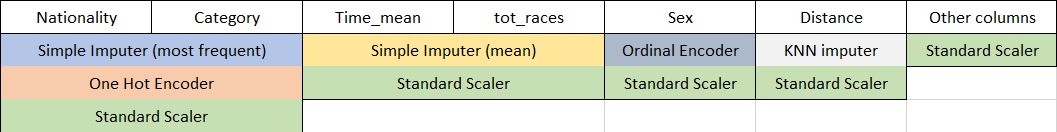

In [72]:
pipeline_nat_cat = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent') ),
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False) )
])

pipeline_timean_race = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler() ),
])

pipeline_sex = Pipeline([
    ('hot', OrdinalEncoder(categories=[['Woman','Man']])),
    ('scaler', StandardScaler() )
])

pipeline_distance = Pipeline([
    ('knn', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

final_transformation = ColumnTransformer(transformers=[
    ('nat_cat', pipeline_nat_cat, ['Nationality','category']),
    ('time_race', pipeline_timean_race, ['Time_mean','tot_races']),
    ('sex', pipeline_sex, ['Sex']),
    ('distance', pipeline_distance, ['Distance']),
    ('rest', StandardScaler(), ['Ranking', 'Rank_mean', 'Rank_max', 'Rank_min', 'Distance_mean', 'Distance_max', 'Distance_min', 'Elevation', 'Elev_mean', 'Elev_max', 'Elev_min', 'Time', 'Time_max', 'Time_min', 'diff_races'])
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

<h2>Training and test</h2>
At this point we can split the dataset between training and test, with a 80/20 ratio (80% training and 20% test), which seems to be the best combination at all.
It is useful, especially in this case, to inlcude also the stratification and the random state, so that there is a sort of balancing of 0/1 labels in train and test set. This is fundamental because this dataset has the first 1100 rows (approximately) of 1 and the others of 0, so without these parameters the test set wouldn't have any 1 label (and the opposite for the train)!

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

as effect, we can see a sort of 'balancing' between 0/1 labels (it is not perfect because even in the datasset it is not 50/50).

In [74]:
y_train.value_counts()

1    890
0    535
Name: finish, dtype: int64

<h2>Choose of the model</h2>

Once defined which are the basic transformations to apply to the dataset (they aren't already applied, since this will be done ONLY on the training set), there are still some problems that can affect the data.
These problems have to be solved if we want to find the best possible model. Overall, this model would reflect the two main solutions to the data problems:

- <b>Imbalanced Classes</b>: This is an actual problem of this dataset, as 60% of samples belong to class A and 40% to class b. The strategy to create a balance is to do operations on the minority class or on the majority;

- <b>Too many dimensions</b>: If there are too many features the created model can be too complex, hence suffering of overfitting (performs well on training data and worse on test data). A great way to prevent such problem is to search a trade-off by having less dimensions without a serious loss of informations.

In general, speaking about trade-offs, the goal is to find a good one between underfitting and overfitting, that means having a model that is nor too simple (unable to perform acceptable classifications) nor too complex (unable to perform well on unseen data).

To reach this goal, we can exploit different imbalanced classes and dimensionality reduction methods, testing the possible compinations of them with the best hyperparameters. All of this is done also for the choice of the best classifier with the best possible hyperparameters.

The workflow is to create a general pipeline, containing an example of what we need:

- The previous transformation (has to be applied);
- a method for imbalanced classes;
- a method for dimensionality reduction;
- a classifier.

The pipeline is the best tool to use in this case, as it contains different transformators (the first three elements in this case) and a predictor (the classifier). An example of Pipeline is:

In [75]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', LogisticRegression())
])

We can use fit and predict to get only one of the desired possibilities.

In [76]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('nat_cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Nationality', 'category']),
                                                 ('time_race',
                                                  Pipeline(steps=[('imp',
 

In [77]:
model_pipeline.predict(X_test)

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

Now we want this pipeline to be specific, and to be the best specific pipeline among all possible ones.
The task of selecting the best pipeline has also to be integrated with another element.
In fact, in addition to the best hyperparameter combination, one would like to be sure also to estimate the ability of generalization of the model.

<h3>Nested cross validation</h3>

The task of obtaining the best hyperparameters is solved by the <b>RandomizedSearch</b>, a method that finds the best hyperparameters with a brute force approach. Then, this method can be "inserted" in a <b> stratified cross validation</b>, in order to get also an estimation of the generalization ability.

<h4>Combinations for the RandomizedSearch</h4>

As the randomized search finds the best combinations of hyperparameters, first of all it is necessary to define all possible combinations, from which the best will be chosen. This means that we have to define all combinations of Imbalance classes, dimensionality reduction and classifiers, everyone with its hyperparameters. Here are the combinations:

- Imbalance classes: As the dataset has few samples, using a downsampling method can lead to underfitting. This means that the possibilities would be to have <b>no strategy</b>, <b>SMOTE</b> or <b>RandomOverSampler</b>;
- Dimensionality reduction: in this matter we have different strategies to test. A first one is <b>SFS</b>, to extract the most important features. Then, as strategy to compress the dimension of feature space with a linear transformation, the choice is for <b>PCA</b>. The last one would like to be the <b>Kernel PCA</b>, in order to consider also the possibility to have non linearly separable classes (in that case KPCA would be the best choice).

The last choice to make is about the classifier. As known, the best classifiers in general can beconsidered to be the ones based on ensemble methods (so on combinations of different simple classifiers), however on a small dataset, if the classes are also liearly separable, it is not strange to expect good performances also from other ones as, for example, logistic regression. Overall, the classifiers chosen would be:

- XGB Classifier: a powerful ensemble classifier based on the gradient descent, usually one of the best;

- Logistic Regression: as said above, performs well if the classes are linearly separable;

- Support Vector Classifier: another interesting classifier, that can be kernelized with the add off the gamma hyperparameter;

- Random Forest: Popular classifier, reduces the overfit issue of decision trees by combining many of them in voting.

Only these four ones were chosen, as otherwise the computational cost of the model would be too high, so it seemd useful to me to exclude a priori some classifiers that are statistically less performative than these ones

In [78]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [KernelPCA()],
        'dim_reduction__n_components' : [0.5, 0.7, 0.9],
        'dim_reduction__kernel' : ['rbf', 'poly', 'sigmoid'],
        'dim_reduction__gamma': [5,15,20]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier__learning_rate' : loguniform(0.001,20),
        'classifier': [XGBClassifier(random_state=1)],
        'classifier__max_depth': [1,3,4],
        'classifier__n_estimators' : [350,500,700]

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [SVC()],
        'classifier__gamma': [3,5,7,9],
        'classifier__kernel' : ['linear','rbf','sigmoid'],
        'classifier__C' : loguniform(0.001,100)
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

Once defined all the possibilities, they have to be combined togheter.

In [79]:
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

With this function we perform the cartesian product between the three dictionaries, and then we merge all them in a dictionary. The result is the list of all possible configurations:

In [80]:
all_configs[3]

{'sampler': [None],
 'dim_reduction': [None],
 'classifier': [RandomForestClassifier()],
 'classifier__n_estimators': [10, 50, 100, 500]}

In [81]:
len(all_configs)

48

Then there is the nested cross validation itself. With it we can test all the configurations of hyperparameters in a randomizesearchCV (randomize search using cross validation), and this give us the '<i>inner loop</i>'.

In [82]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

Now, to complete the nested cross validation we need to implement the outer loop, which can be done by using a normal cross validation, taking the randomized grid search as input

In [83]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3, error_score='raise') #

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.746 total time= 1.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] END ......................................., score=0.770 total time= 1.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s


[CV] END ......................................., score=0.736 total time= 2.9min
[CV] END ......................................., score=0.768 total time= 1.6min
[CV] END ......................................., score=0.762 total time= 3.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.7min finished


In [84]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(n_jobs=-1, sampling_strategy=0.7)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012980721367219127,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...) {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score'

In analyzing the performances of the model, we can see that the best one is obtained by the Logistic Regression, without any imbalaced classes and dimensional analysis method.
This can find explanation in the fact that, everything considered, the dataset it's relatively too small to see the benefits of dimensionality reduction, and probably the imbalancing between classes didn't affected too much the performances (performances are actually better without it!).

The nested cross validation acts on splits of the training set, then uses one fold at time to test. This means that the performances above do not refer to the entire training set, but on the restriced part taken by the nested CV. Now that we know the best estimators we can run them on the entire training set, then test them on the test set.

In [85]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.778414517669532, F1 on test set:0.7651515151515151
F1 on training set:1.0, F1 on test set:0.7702936096718481
F1 on training set:0.7744565217391304, F1 on test set:0.7686703096539163
F1 on training set:1.0, F1 on test set:0.7708333333333333
F1 on training set:0.7706255666364461, F1 on test set:0.7670250896057348


And from this result we can see that other classifiers that seemed to be better, in reality suffer from high overfitting, while logistic regression remains the one with better generalization capacity

<h3>Refinement of the model</h3>

As a comment on these results we can first see that the random forest and XGBoost are enormously overfitted, and also, the best performances are obtained by the Logistic Regression, with different C and l1_ratio values.
By knowing this last fact we can try to refine the model to increase its performances, that is, trying to 'zoom' in the interval of C found to see if there is a better one.
This traduces concretely in find a possibly new C in a sort of 'confidence interval'. C will be selected on a Uniform R.V. on [0,001,0,1].
Then, by running the program several times, on average the best f1 score also included (as mode) PCA and RandomOverSampler. Also based on modes, the values of hyperparameters were taken.
All this traduces in another GridSearch, to find the best combination of these hyperparameters.
But before passing to this, we construct a new definitive pipeline.


In [86]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', RandomOverSampler()),
    ('dim_reduction',PCA()),
    ('classifier',LogisticRegression(solver='saga'))
])

So, as before, we can combine all the possibilities of hyperparameters and then run a RandomizedGridSearch on them, to get the really best combination of hyperparameters.

In [87]:
classifier_configsb = [{
    'classifier__C': uniform(loc = 0.001, scale = 0.1 ), #Unif[loc, loc + scale]
    'classifier__penalty' : ['l1','l2', None ]
}]

sampler_configsb = [{
    'sampler__sampling_strategy': uniform(loc = 0.1, scale = 0.6 ) #Unif[loc, loc + scale]
}]

dim_reduction_configsb = [{
    'dim_reduction__n_components': uniform(loc = 0.2, scale = 0.8 ) #Unif[loc, loc + scale]
}]


In [88]:
all_configs2 = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(sampler_configsb,dim_reduction_configsb,classifier_configsb)]

In [89]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = all_configs2,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1'
)

In [90]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('nat_cat',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore')),
                                                                           

As we got the fit, now we can obtain the score on the test set. The best combination is:

In [91]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('nat_cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Nationality', 'category']),
                                                 ('time_race',
                                                  Pipeline(steps=[('imp',
 

At last, we can get the f1 score for this final and definitive pipeline.

In [92]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.7495495495495496

<h2>Performance evaluation</h2>

The f1 score is the most 'informative' score that can be get from the confusion matrix, so it is enough to have this to get the overall accuracy of the model on this aspect.
Thus, there are other meaningful datas about performance to analyze.
First of all, we can see how the training and validation performances change according to the size of training set, so the number of samples used to generate the curve. Beyond this it's also interesting to include in the plot the standard deviation of such measurements.

<h3>Learning curve</h3>

In [93]:
cls = rs_best.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

(0.6, 1.03)

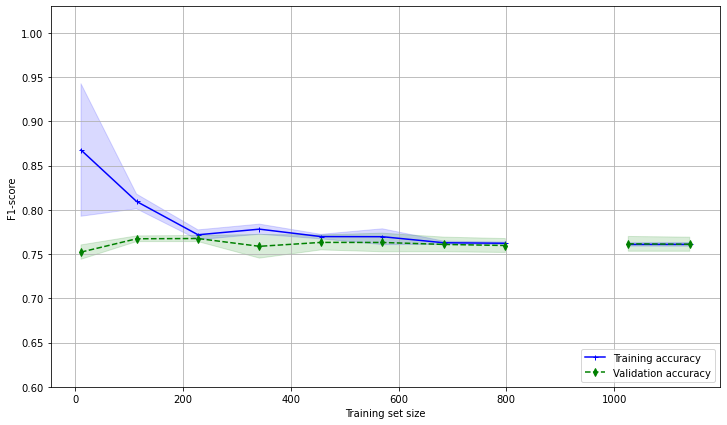

In [94]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

As we can see, if few training samples areused the model tends to overfit (really prevedible), but with the increase of the samples used the training and validation accuracy tend to merge, a sign of a good variance-bias tradeoff. It is acceptable because the bias is controlled (the performance is around 0,75), but also the variance is, as there is not much overfitting between training and validation (the difference is around 0,1, which is more than acceptable).

<h3>Validation curve</h3>

Another significative graph for the bias/variance evaluation is the validation curve, in which we plot the score of the classification for both validation and tranining in function of the Hyperparameters, to see the variation.
In the definitive pipeline we had more than one hyperparameter, so it would be ideal to have a validation curve for each one of them.

<h4>C</h4>

this, among all, it's probably themost effective hyperparamerer to have, as it's directly involved in the classification. C is the opposite of the regularization strenght.

In [95]:
range_C = [0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.05, 100)

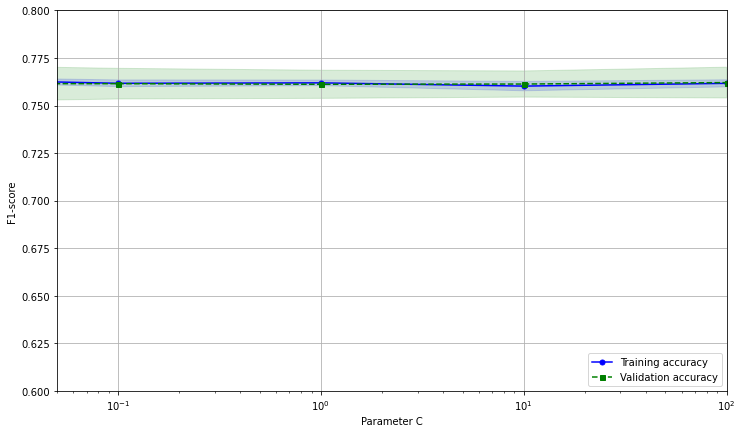

In [96]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.8])
ax.set_xscale('log')
ax.set_xlim([0.05,100])

From the graph we can see that the choice of C doesn't impact much on the accuracy.

<h4>n_components</h4>

This parameter comes from PCA, and can represent different things inbase on the values that assumes. In particular, if it is between zero and one it represents the <b>cumulative explained variance</b> we want to keep from the original dataset, that traduces in the amount of informations that we want to keep. If the value is superior to one, it represents the exact number of features that we want in the projection of the original dataset, so, the number of eigenvectors to include in the transformation matrix.
In our case, as the parameter is less than one, the range of variation will be between 0 and 1.

In [97]:
range_n = [0.1,0.5,0.7,0.9,1]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_n, 
        param_name='dim_reduction__n_components',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.1, 1.0)

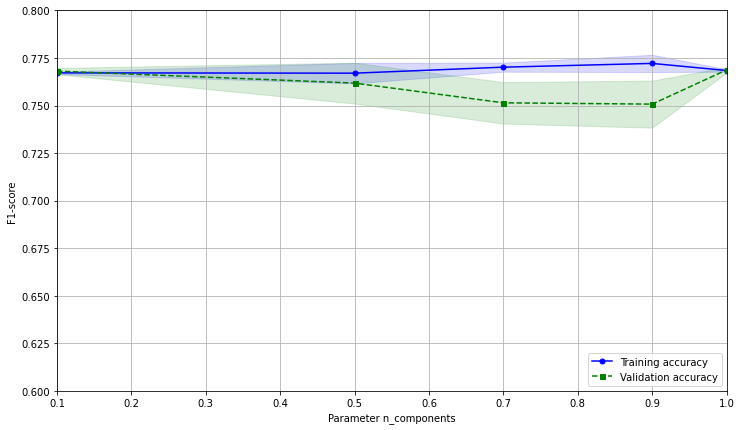

In [98]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_n, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_n,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_n, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_n,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter n_components')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.8])
#ax.set_xscale('log')
ax.set_xlim([0.1,1])

From this graph we can observe that the validation is more sensitive to the parameter than the training, but also that the best performance is kept at n=1 (expected, because there is no information loss). An accpetable result is betweem 0.7 and 0.9, where the trade off between the lenght of computations and the performances is quite balanced.

<h4>Sampling strategy</h4>

This parameter belongs to the imbalanced classes methods. In particular,it represents the <b>final ration</b> (so after the application of the sampling) between the minority class and the majority class, expressed as number of samples.

In [99]:
range_s = [0.1,0.5,0.7,0.9,1]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_s, 
        param_name='sampler__sampling_strategy',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.7, 1.0)

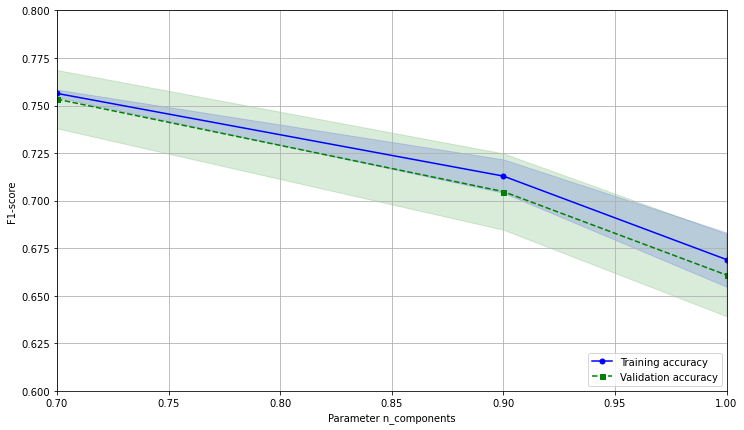

In [100]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_n, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_n,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_n, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_n,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter n_components')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.8])
#ax.set_xscale('log')
ax.set_xlim([0.7,1])

This reflects quite an interesting behavour, because the accuracy is higher when the ratio is about 0.7, and decreases when the ration reaches 1. This can be explained by the fact that, even the new samples are not totally random generate, if there are too many (considering also the starting point), the gain of information stored in the true samples can be sort of overcomed by the new ones. Also, with the increase of their number, also their overall randomicity shall increase.

<h3>Final considerations on classification</h3>

Discussing this model on classification, first of all we can say that the model (fortunately) does not tend to overfit. Another remarkable thing is that the performance is not too poor, taking into consideration the fact that the dataset wasn't ready but manipulated in this project, and also the fact that the samples weren't too many.

<h1>Regression</h1>
The point now is that most of the part of classification can be re-used also for the regression task.

The structure is the same of before. Now, a very interesting part is the EDA, to see the correlations between data and target value. This beacuse now we don't want to predict whether a sample belongs to a class, but we want to generate a nubmer from each sample, that has to be next to the target one. THe nubmers generated are used then to define a regreswsion function, for generalize on new unseen data. This means that the target value becomes a <b>function</b> of the features. The goal of EDA now is to see if there are some patterns linking the data.


<h2>Explorative Data Analysis</h2>

Our matrix has certain number of features. Obviously, in this case we can't visualize all the correlations togheter, as there are 26 features, but we can see them in couples, so with 26x26 different graphs of a feature in function of another, collected in the so called <b>scatterplot matrix</b>. 

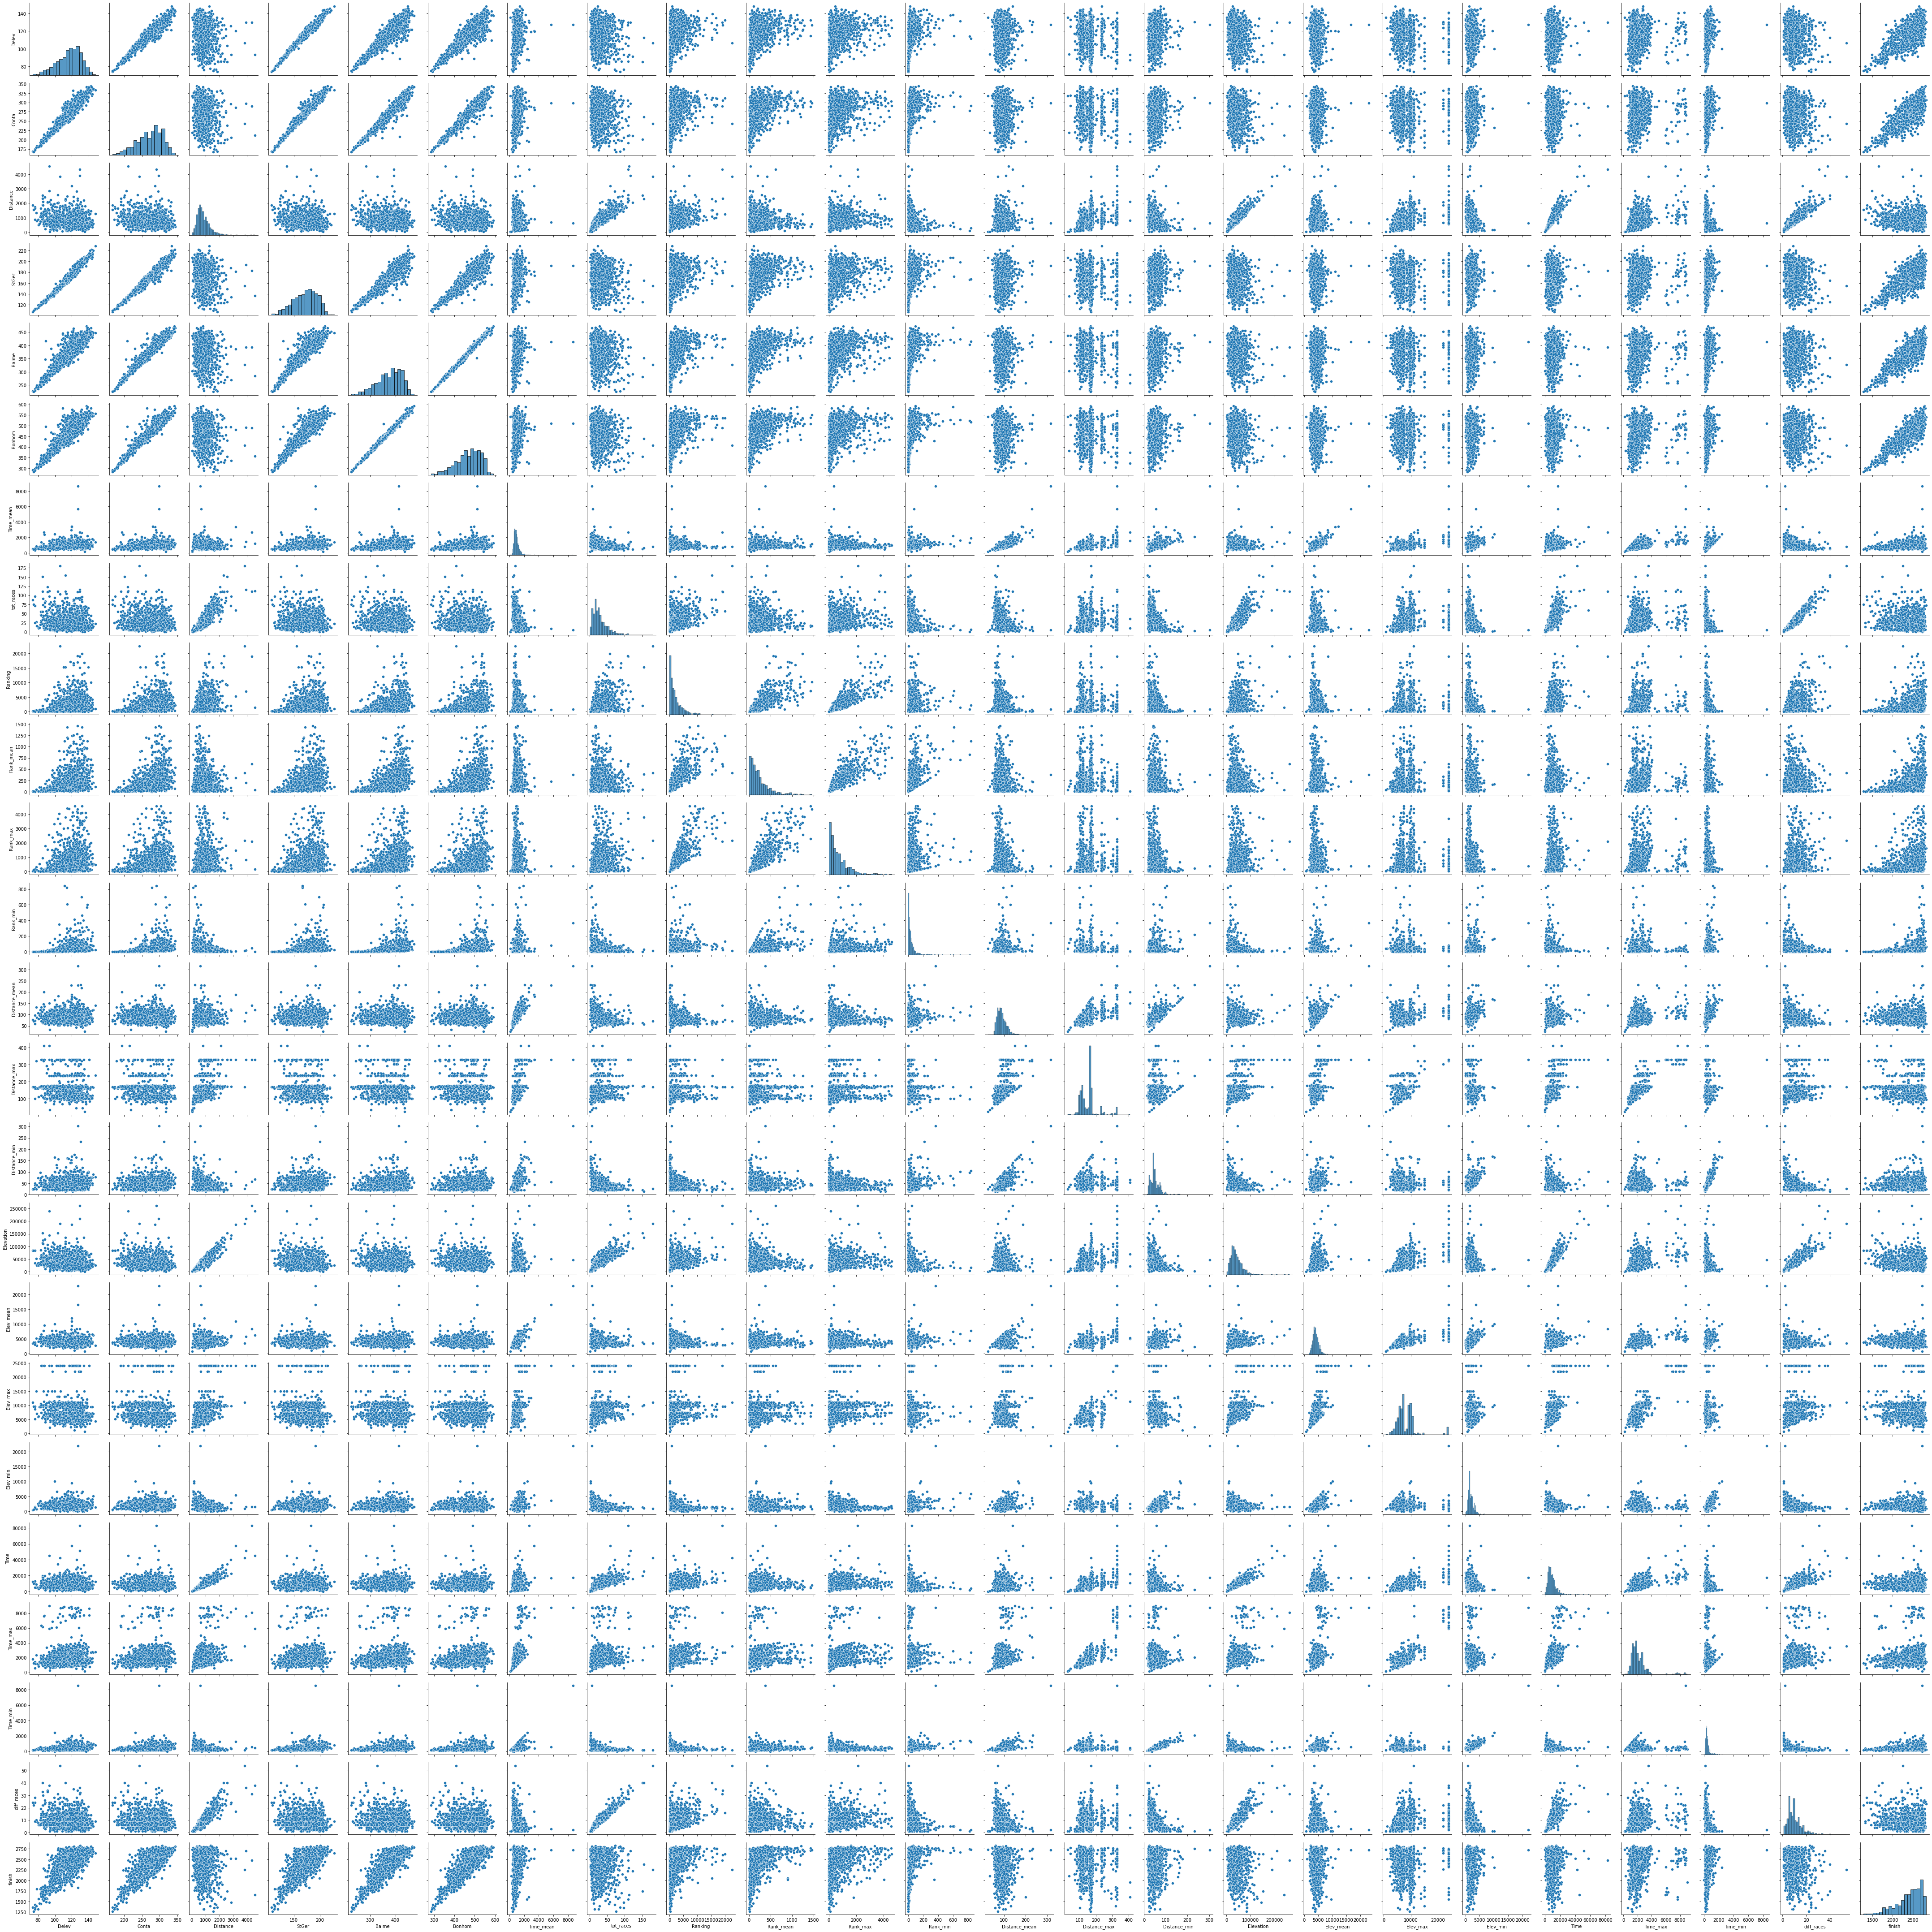

In [101]:
cols = ['Nationality','category','Delev','Conta','Sex','Distance','StGer','Balme', 'Bonhom','Time_mean','tot_races','Ranking', 'Rank_mean', 'Rank_max', 'Rank_min', 'Distance_mean', 'Distance_max', 'Distance_min', 'Elevation', 'Elev_mean', 'Elev_max', 'Elev_min', 'Time', 'Time_max', 'Time_min', 'diff_races','finish']
sns.pairplot(df_regdef[cols], size=2.5)
plt.tight_layout()
plt.show()

On the diagonal we have all histograms, this because they are referredto the dependece of certain feature with itself. But, we can notice different cells in which the depence assumes the shape of a line, suggestig a linear depence. On other graphs we can see a sort of hyperbolic shape, or even some other histograms.

Another way to see the correlation between couples of features is via Correlation coefficient. This number, taken from probability theory, establishes the correlation between two features X,Y as the ration between their <b>covariance</b> and the product of their <b>standard deviation</b>. Again, this is done with all possible couples of features. This number is from -1 to 1. If it is 0 the features are uncorrelated, if it is 1 they are (perfectly) positive correlated (they vary togheter positively from their mean, as Cov(X,Y)>0), while if it is -1 they are (perfectly) negative correlated (in this case they vary togheter below their mean, as Cov(X,Y)<0).

In [102]:
dfmat = df_regdef.apply(pd.to_numeric, errors="ignore") 

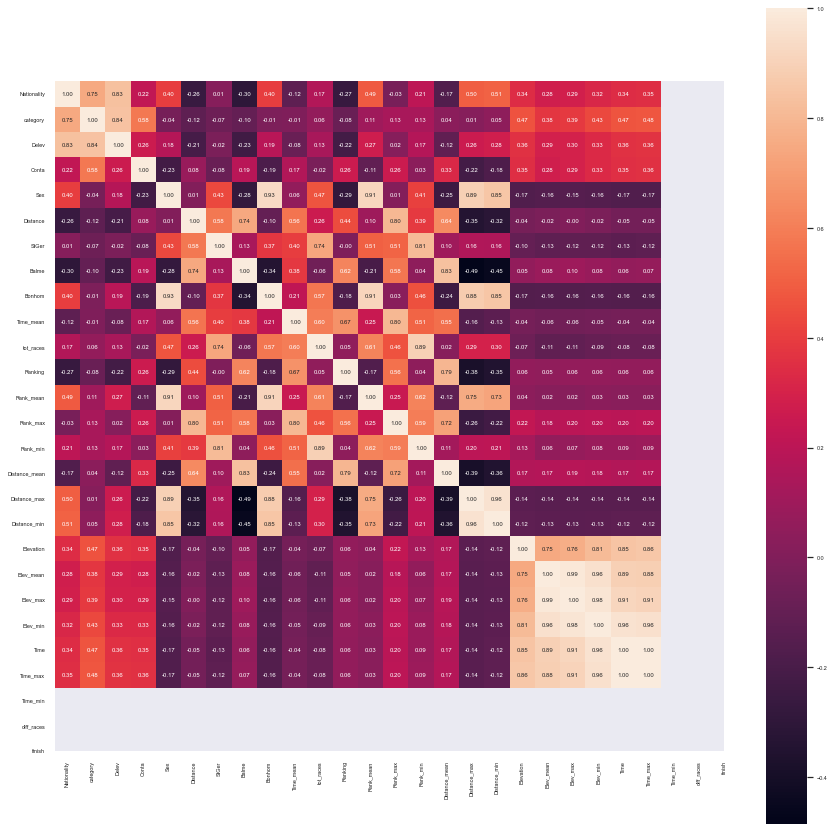

In [103]:
cm = np.corrcoef(dfmat.select_dtypes("number").values.T)
sns.set(font_scale=0.5,rc={'figure.figsize': (15, 15)})
hm = sns.heatmap(cm,
                        cbar=True,
                        annot=True,
                        square=True,
                        fmt='.2f',
                        annot_kws={'size': 6},
                        yticklabels=cols,
                        xticklabels=cols)
plt.show()

How to interpret this?
First of all, notice the colors, the 'best' cases (1,-1), so the ones in which the correlation between two features is stronger, are colored in black for -0.4 (even tought the correlation is negative, it it still strong), while if the correlation is 1 the color is the lighter possible.
Notice that on the diagonal there is the correlation of pairs (i,i), and this is obviously one.
Then, for all other cells, the more are light the more correlation is next to one, and the more are dark the more is next  to -0.4. The independent case (0), is sort of violet. 
There are many features that show a dependence, positive or negative, but also many that are poorly correlated. Then, the blanck part of the square is referred to the missing values.

<h2>Data Preprocessing</h2>

Now we split between feature matrix and label vector, as before.

In [104]:
Xr , yr = df_regdef.drop(['finish'], axis=1) , df_regdef['finish']

In [105]:
Xr

Ranking   Rank_mean  Rank_max  Rank_min  Distance  Distance_mean  \
0       120.0   40.000000      58.0      19.0     371.0     123.666667   
1      2415.0  185.769231    1271.0       3.0    1508.7     116.053846   
2      1137.0   54.142857     254.0       6.0    1477.7      70.366667   
5       809.0   80.900000     391.0       7.0     871.8      87.180000   
11     2127.0  265.875000     758.0      70.0     640.7      80.087500   
...       ...         ...       ...       ...       ...            ...   
1773    462.0  115.500000     178.0      85.0     283.6      70.900000   
1774   2183.0  218.300000     693.0       9.0     808.7      80.870000   
1775   7738.0  967.250000    2870.0      96.0     640.8      80.100000   
1777    627.0  156.750000     501.0      12.0     337.5      84.375000   
1779   1819.0  303.166667     730.0      36.0     659.7     109.950000   

      Distance_max  Distance_min  Elevation    Elev_mean  ...  diff_races  \
0            161.0          84.5       9890  3296.666667  ...           3   
1            201.5          55.6      75680  5821.538462  ...          13   
2            164.0          42.2      86170  4103.333333  ...          21   
5            167.7          58.0      51630  5163.000000  ...          10   
11           129.7          54.3      29650  3706.250000  ...           8   
...            ...           ...        ...          ...  ...         ...   
1773         140.0          37.0      18260  4565.000000  ...           4   
1774         172.6          40.9      48910  4891.000000  ...          10   
1775         103.5          60.0      39260  4907.500000  ...           8   
1777         101.0          74.0      17600  4400.000000  ...           4   
1779         168.0          97.1      28630  4771.666667  ...           6   

      tot_races  Sex     Nationality  category       Delev       StGer  \
0            12  Man          Canada      SE H  121.516667  181.250000   
1            36  Man         Hungary      SE H  121.150000  172.083333   
2            55  Man           Italy      V1 H  116.050000  161.483333   
5            26  Man     Switzerland      SE H  100.566667  158.866667   
11           25  Man          Latvia      V1 H  129.633333  188.150000   
...         ...  ...             ...       ...         ...         ...   
1773         10  Man          France      V1 H  138.333333  200.200000   
1774         34  Man          France      SE H  106.050000  152.883333   
1775         25  Man          France      V1 H  137.900000  206.533333   
1777         10  Man  United Kingdom      V1 H  140.183333  208.716667   
1779         15  Man           China      V2 H  115.000000  173.216667   

           Conta       Balme      Bonhom  
0     286.300000  390.316667  483.733333  
1     256.616667  335.966667  418.666667  
2     249.850000  338.250000  426.183333  
5     252.350000  356.800000  440.600000  
11    298.916667  406.966667  505.883333  
...          ...         ...         ...  
1773  323.583333  446.500000  558.750000  
1774  243.400000  352.533333  509.600000  
1775  325.866667  456.666667  583.450000  
1777  326.750000  431.300000  536.250000  
1779  273.933333  381.900000  476.716667  

[1110 rows x 26 columns]

In [106]:
yr

0       2513.016667
1       1986.650000
2       2300.350000
5       2382.783333
11      2645.633333
           ...     
1773    2652.516667
1774    2545.166667
1775    2686.233333
1777    2662.583333
1779    2715.400000
Name: finish, Length: 1110, dtype: float64

Now as before, eliminate some values, but this time also something from the checkpoint times, to not have too many suggestions on the final target.

In [107]:
colnr = list(Xr.columns)
print(colnr)

['Ranking', 'Rank_mean', 'Rank_max', 'Rank_min', 'Distance', 'Distance_mean', 'Distance_max', 'Distance_min', 'Elevation', 'Elev_mean', 'Elev_max', 'Elev_min', 'Time', 'Time_mean', 'Time_max', 'Time_min', 'diff_races', 'tot_races', 'Sex', 'Nationality', 'category', 'Delev', 'StGer', 'Conta', 'Balme', 'Bonhom']


In [108]:
lengthr = len(colnr)

Then, we can insert some missing values again:

In [109]:
num = int(random.uniform(0,0.04)*lengthr)
idx_replace = np.random.randint(0, lengthr-1, num)
print(num)
Xr.loc[idx_replace, 'category'] = np.nan
num = int(random.uniform(0,0.04)*lengthr)
idx_replace = np.random.randint(0, lengthr-1, num)
print(num)
Xr.loc[idx_replace, 'Delev'] = np.nan
num = int(random.uniform(0,0.04)*lengthr)
idx_replace = np.random.randint(0, lengthr-1, num)
print(num)
Xr.loc[idx_replace, 'Distance'] = np.nan
num = int(random.uniform(0,0.04)*lengthr)
idx_replace = np.random.randint(0, lengthr-1, num)
print(num)
Xr.loc[idx_replace, 'Conta'] = np.nan
num = int(random.uniform(0,0.04)*lengthr)
idx_replace = np.random.randint(0, lengthr-1, num)
print(num)
Xr.loc[idx_replace, 'Nationality'] = np.nan


0
0
0
0
0


The final transformation remains the same, but we have to add an imputer for the two checkpoint columns and also standardize all them.

In [110]:
pipeline_nat_cat = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent') ),
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False) )
])

pipeline_del_conta = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler() ),
])

pipeline_sex = Pipeline([
    ('hot', OrdinalEncoder(categories=[['Woman','Man']])),
    ('scaler', StandardScaler() )
])

pipeline_distance = Pipeline([
    ('knn', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

final_transformationr = ColumnTransformer(transformers=[
    ('nat_cat', pipeline_nat_cat, ['Nationality','category']),
    ('time_race', pipeline_del_conta, ['Delev','Conta']),
    ('sex', pipeline_sex, ['Sex']),
    ('distance', pipeline_distance, ['Distance']),
    ('rest', StandardScaler(), ['StGer','Balme', 'Bonhom','Time_mean','tot_races','Ranking', 'Rank_mean', 'Rank_max', 'Rank_min', 'Distance_mean', 'Distance_max', 'Distance_min', 'Elevation', 'Elev_mean', 'Elev_max', 'Elev_min', 'Time', 'Time_max', 'Time_min', 'diff_races'])
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

<h2>Training and test</h2>

Again, split the dataset between train and test set.

In [111]:
yr

0       2513.016667
1       1986.650000
2       2300.350000
5       2382.783333
11      2645.633333
           ...     
1773    2652.516667
1774    2545.166667
1775    2686.233333
1777    2662.583333
1779    2715.400000
Name: finish, Length: 1110, dtype: float64

In [112]:
X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr, yr, test_size=0.2, random_state=30, shuffle=True)

<h2>Choose of the model</h2>

The pipeline remains quite the same, only the polynomial features were added, in case of non-linera relartions. Another change is that the method for imbalance classes doesn't make sense anymore, as there are no more classes but a continous target to predict.

In [113]:
model_pipeliner = Pipeline([
    ('trans', final_transformationr),
    ('dim_reduction', PCA(n_components=0.8)),
    ('polynomial', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

In [114]:
model_pipeliner.fit(X_trainr,y_trainr)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('nat_cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Nationality', 'category']),
                                                 ('time_race',
                                                  Pipeline(steps=[('imp',
 

In [115]:
model_pipeliner.predict(X_testr)

array([ 2.74906250e+03,  2.11687500e+03,  3.16131250e+03,  1.94996875e+03,
        2.34412500e+03,  2.47328125e+03,  3.96126875e+04, -2.01186988e+06,
        2.19640625e+03, -1.30562869e+06,  2.32303125e+03,  2.00087500e+03,
        1.04515625e+03,  3.25600000e+03, -3.46168750e+03,  5.48119066e+06,
        2.21151456e+07,  2.54326897e+06,  3.08359375e+03,  1.99325000e+03,
        2.35510656e+05,  2.84625000e+03,  1.78674375e+04, -1.44881394e+06,
        4.06662500e+03,  2.17921875e+03,  2.81331250e+03, -4.29649375e+05,
        2.57309375e+03, -2.66067731e+06,  2.41659375e+03,  2.85456409e+06,
        2.27825000e+03,  2.08634375e+03,  1.94375000e+03,  2.56578125e+03,
        2.17909375e+03,  2.36637500e+03,  2.98800000e+03, -6.93937500e+02,
       -2.43389219e+05,  1.61503125e+03,  2.81081250e+03, -1.94226250e+04,
        2.86334441e+06,  2.86653125e+03,  2.46728125e+03,  2.56462500e+03,
        2.05040625e+03,  1.21576719e+05,  2.65690625e+03,  7.70704062e+05,
        2.90831250e+03,  

After seeing that the pipeline works, it's time to define the configurations for the grid search. The dimensionality reduction remains the same as before, but now there are plenty of new things.

<h4>Polynomial</h4>

The target continous variable yr can be correlated in different ways with the features, there can be a linear correlation (of type y = wx) or a non-linear one. The most common case of non-linear combination is the Polynomial one. To search for such combination we don't use a particular type of regressor, the strategy is to trasform the feature matrix X in base on the degree of the polynomial, and then perform the regresion. In this case the possible degrees chosen were 1 (normal y = wx), 2 and 3.

<h4>Regressors</h4>

There are many different regressors, but in this project i only put ones from the Rashka book.
The first is <b>LinearRegression</b>, that captures linear correlations between data and the target (this could also use a modification of the gradient descent algorithm, in this case with a continous loss function). This regressor has no hyperparameters in this case.
Then there is the <b>RANSAC</b> regressor, which offers a solution on the so called <i>'outliers</i>, so the points that are very far from the trend (and that can negatively affect the regression). The RANSAC works by choosing a certain minimum sumber of samples from the dataset (min_samples) and performing a Linear regression on them (in this case). Then, from these ones excludes some that are too far from the regression (the tolerance is vertical in this cas), and resamples again, until reaches the set number.
So the hyperparameters are the min_samples, the residual_threshold and the max_trials.
Another important regressor is <b>ElasticNet</b>, which uses regularization on the loss function to increase performance. In particular, it uses both l1 and l2 regularizations to improve the performances of the LASSO regressor. Here the hyperparameters are '<i>alpha</i>', which is strictly correlated with the regularization strenght, thene there is the strenght of the l1 regularization (if put to 1 we get exactly the LASSO regressor).
Then at last we have the <b>Random forest regressor</b>. This regressor overcomes the generalizatin problem of decision tree regressor, and it's also less sensitive to outliers. As in the other case the main hyperparameters to tuning are the maximum depth of the trees and also the number of them.
Then, in this case we also have an hyperparameter correlated with the evalutaion of the performance, so we have to choose to use the <b>mean square error</b> or the <b>mean absolute error</b>

In [116]:
dim_reduction_configs = [
    #{
    #    'dim_reduction': [None]
    #},
    #{
    #    'dim_reduction': [PCA()],
    #    'dim_reduction__n_components': [0.5, 0.7, 0.9]
    #},
    #{
    #    'dim_reduction': [KernelPCA()],
    #    'dim_reduction__n_components' : [0.5, 0.7, 0.9],
    #    'dim_reduction__kernel' : ['rbf', 'poly', 'sigmoid'],
    #    'dim_reduction__gamma': [5,15,20]
    #},
    #{
    #    'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
    #    'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
    #    'dim_reduction__k_features' : [5,7,10]  
    #}
]

#polynomial_configs = [
#    {
#        'polynomial__degree': [1,2,3]
#    }
#]

#regressor_configs = [
    #{
    #    'regressor': [LinearRegression()]
    #},
    #{
    #    'regressor': [RANSACRegressor(LinearRegression(),loss='absolute_loss')],
    #    'regressor__max_trials' : [60,80,100],
    #    'regressor__min_samples': [30,50,70],
    #    'regressor__residual_threshold' : uniform(3,5)
    #},
    #{
    #    'regressor': [ElasticNet()],
    #    'regressor__alpha': [0.5,1,1.5],
    #    'regressor__l1_ratio' : uniform(0.1,0.8),
    #},
    #{
    #    'regressor' : [RandomForestRegressor(n_jobs=-1)],
    #    'regressor__n_estimators' : [100,500],
    #    'regressor__criterion' : ['mse','mae'],
    #    'regressor__max_depth' : [5,None]
    #}
#]

<i>edit:</i> after several times trying to run the whole code, i had to shut it down after 12 hrs of running. Then i started running smaller combinations one at time. Here is what i found out:

- The 'polynomial features' it's unuseful, because the degree of the best single performances was 1 everytime, so i left it commented;
- By running each regressor everytime, the only dimensionality reduction teqnique emerged to be the PCA, but after trying to run again the model wihtout it many times, the performances didn't change, so for computation costs i decided to left also this as commented;
- Generally the best regressors turned out to be LinearRegression and Random forest, but with this last i had to be very careful. This because the time cost can be easyly really high, in particular, if the maximum depth of the trees is higher than 10, to run a single fold of cv the time is about 3 hours, so for this reason the maximum of depth in the list of hyperparameters is 10. With regards to the number of trees, this is not a big issue.

For the purpose of the project i didn't cancelled the code, i only left it commented, to show how i would had work if the runtime wasn't so high.

In [117]:
#all_configsr = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(regressor_configs)]

In [118]:
#len(all_configsr)

1

In [119]:
#rsr = RandomizedSearchCV(model_pipeliner,
#    param_distributions=all_configsr,
#    n_iter=len(all_configsr) * 5,
#    n_jobs=-1,
#    cv = 2,
#    scoring='r2'
#)

In [ ]:
#scoresr = cross_validate(rsr, X_trainr, y_trainr, scoring='r2', cv = 5, return_estimator=True, verbose=3, error_score='raise')

In [ ]:
#for index, estimator in enumerate(scoresr['estimator']):
#    print(estimator.best_estimator_.get_params()['polynomial'])
#    print(estimator.best_estimator_.get_params()['dim_reduction'])
#    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
#    print(scoresr['test_score'][index])
#    print('-'*10)

In [ ]:

#for estimator in scoresr['estimator']:
#    pred_train = estimator.best_estimator_.fit(X_trainr, y_trainr)
#    pred_train = estimator.best_estimator_.predict(X_trainr)
#    pred_test = estimator.best_estimator_.predict(X_testr)
#    r2_train = r2_score(y_trainr, pred_train)
#    r2_test = r2_score(y_testr, pred_test)
#    print(f'F1 on training set:{r2_train}, F1 on test set:{r2_test}')

As the comments above say, the best classifiers were random forest and linear regression, without dimensionality reduction and polynomial features teqniques. The purpose now is to run a nested cross validation to verify which is the best one among these two and (in the case of random forest) also its hyperparameters. The nested cross validation turned out to finish in reasonable times including only these two elelments. Furthermore, the exclusion of the other combinations does not affect the performances at all, relying on the previous observations. 

In [197]:
pipd = Pipeline([
    ('trans', final_transformationr),
    ('regressor', RandomForestRegressor())
])

In [198]:
regressor_configs = [
    {
        'regressor' : [RandomForestRegressor(n_jobs=-1)],
        'regressor__n_estimators' : [100,200,300,400],
        'regressor__criterion' : ['mse','mae'],
        'regressor__max_depth' : [2,3,5,None]
    },
    {
        'regressor': [LinearRegression()]
    },
]

In [199]:
rsrp = RandomizedSearchCV(pipd,
    param_distributions=regressor_configs,
    n_iter=len(regressor_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='r2'
)

In [194]:
scoresrp = cross_validate(rsrp, X_trainr, y_trainr, scoring='r2', cv = 5, return_estimator=True, verbose=3, error_score='raise')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.603 total time= 2.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV] END ......................................., score=0.739 total time= 3.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.6min remaining:    0.0s


[CV] END ......................................., score=0.616 total time= 3.9min
[CV] END ......................................., score=0.691 total time= 6.4min
[CV] END ......................................., score=0.666 total time= 3.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.9min finished


In [195]:
for index, estimator in enumerate(scoresrp['estimator']):
    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
    print(scoresrp['test_score'][index])
    print('-'*10)

RandomForestRegressor(criterion='mse', max_depth=3, n_estimators=300, n_jobs=-1) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.60298043349692
----------
RandomForestRegressor(criterion='mse', max_depth=5, n_estimators=400, n_jobs=-1) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7389041319562634
----------
RandomForestRegressor(criterion='mae', max_depth=3

As we can see,the random forest turned out to be the best regressor in every case, suggesting that the relation between the features and the target is nor linear nor polynomial, and follows a different 'shape'. Another obseevable fact is that the random forest is really sensitive to the choice of hyperparameters, in fact by changing them the r2 score changes in a not negligible scale. Now we can take the scores of these combinations on the whole dataset.

In [196]:
for estimator in scoresrp['estimator']:
    pred_train = estimator.best_estimator_.fit(X_trainr, y_trainr)
    pred_train = estimator.best_estimator_.predict(X_trainr)
    pred_test = estimator.best_estimator_.predict(X_testr)
    r2_train = r2_score(y_trainr, pred_train)
    r2_test = r2_score(y_testr, pred_test)
    print(f'r2 on training set:{r2_train}, r2 on test set:{r2_test}')

r2 on training set:0.731879500784451, r2 on test set:0.6156069558663277
r2 on training set:0.8448630484697909, r2 on test set:0.6302042808993595
r2 on training set:0.7220545074380853, r2 on test set:0.6329748105504283
r2 on training set:0.9556672033689873, r2 on test set:0.6476115549475976
r2 on training set:0.8248718525592019, r2 on test set:0.6443358846750444


These scores seem to be overfitted, but maybe with a refinement on the model by tuning again the hyperparameters the situation could possibly get better.

<h3>Refinement of the model</h3>

Now that we have a definite structure for the pipeline, we can proceed to tune again the hyperparameters of the random forest, hoping to solve the overfitting issue.

In [205]:
defpip = Pipeline([
    ('trans', final_transformationr),
    ('regressor', RandomForestRegressor())
])

In [206]:
all_configsr2 = [{
        'regressor' : [RandomForestRegressor(n_jobs=-1)],
        'regressor__n_estimators' : [300,330,360,400],
        'regressor__criterion' : ['mse','mae'],
        'regressor__max_depth' : [2,3,4,5]
    }
]

In [207]:
reg_best = RandomizedSearchCV(
    estimator = defpip,
    param_distributions = all_configsr2,
    cv = 2,
    n_iter=20,
    scoring='r2'
)

In [208]:
reg_best.fit(X_trainr,y_trainr)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('nat_cat',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore')),
                                                                                               ('scaler',
                                   

Now we can check what is the best combination of hyperparameters.

In [209]:
reg_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('nat_cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Nationality', 'category']),
                                                 ('time_race',
                                                  Pipeline(steps=[('imp',
 

And at last, check how performs in the test set:

In [211]:
r2_score(y_testr, reg_best.best_estimator_.predict(X_testr))

0.7297572401757819

Now it's time to evaluate its performance. As score i decided to take the r2 among all others (also above for the randomized search and nested cross validation), because it seemed to be the most 'complete' one. This because r2 is a scaled version of the MSE (the sum of differences between predictions and real values divided by the number of samples), which keeps it more interpretable. The range of this score is from minus infinite to 1. As it is defined as the difference between one and the scaled MSE, if r2 is equal to one then the MSE is exactly 0, sign of a perfect regression. Clearly, as the MSE increases the value can converge to minus infinite for very bad regressions. In this case the result is satisfiable, as it is quite next to one.

<h2>Performance evaluation</h2>

We can try to use the same basic idea to plot the performances of the model with learning and validation curves. 

<h3>Learning curve</h3>

In [212]:
clsr = reg_best.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(clsr,
                                                       X=X_trainr,
                                                       y=y_trainr,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'r2',
                                                       shuffle = False)

(0.3, 1.03)

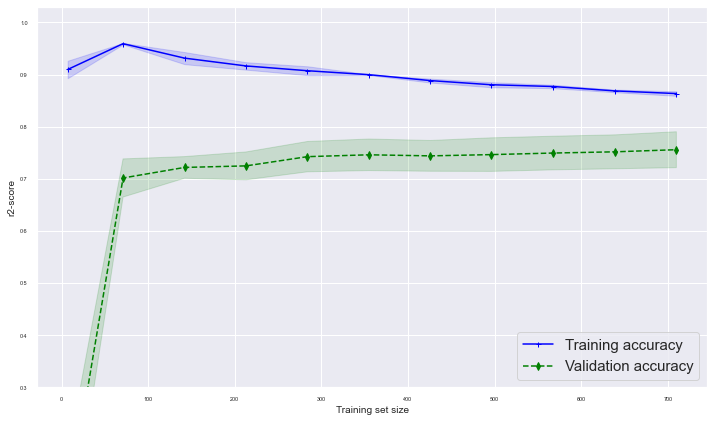

In [214]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid(b=True)
ax.set_xlabel('Training set size', fontsize=10)
ax.set_ylabel('r2-score',fontsize=10)
ax.legend(loc='lower right', fontsize=15)
ax.set_ylim([0.30, 1.03])

As a comment on this result, as the training set size increases the displacement between training and validation accuracy decreases. The model appears to be slightly overfitted, this can be a result of using the random forest estimator, that tends to overfit itself (but, taking this into account, this remains still the highest score on the test).
Another thing that emerges is that the test score is more 'variable'.

<h3>Validation curve</h3>

Another interesting thing is to try to see how the performances change according to the hyperparameters of the random forest.
In particular, as there are two hyperparameters, the subject is to see how the r2 score changes according to each single one.

In [215]:
range_t = [300,330,360,400]
train_scorest, test_scorest = validation_curve(clsr,
        X=X_trainr, 
        y=y_trainr, 
        param_range=
        range_t, 
        param_name='regressor__n_estimators',
        cv=5, 
        n_jobs=-1, 
        scoring='r2'
)

In [216]:
range_d = [2,3,4,5]
train_scoresd, test_scoresd = validation_curve(clsr,
        X=X_trainr, 
        y=y_trainr, 
        param_range=
        range_d, 
        param_name='regressor__max_depth',
        cv=5, 
        n_jobs=-1, 
        scoring='r2'
)

(300.0, 400.0)

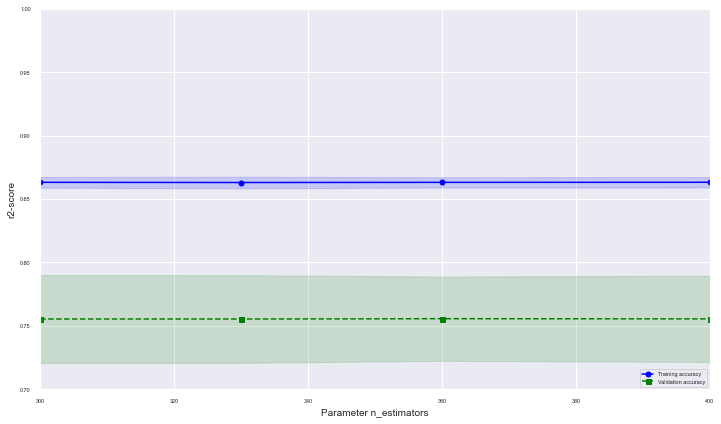

In [226]:
train_meant = np.mean(train_scorest, axis=1)
train_std = np.std(train_scorest, axis=1)
test_meant = np.mean(test_scorest, axis=1)
test_stdt = np.std(test_scorest, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_t, train_meant,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_t,
                 train_meant + train_stdt,
                 train_meant - train_stdt,
                 alpha=0.15, color='blue')

ax.plot(range_t, test_meant,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_t,
                 test_meant + test_stdt,
                 test_meant - test_stdt,
                 alpha=0.15, color='green')

ax.grid(b=True)
ax.set_xlabel('Parameter n_estimators',fontsize=10)
ax.set_ylabel('r2-score',fontsize=10)
ax.legend(loc='lower right')
ax.set_ylim([0.7,1])
ax.set_xlim([300,400])

According to the previous observation, there is a slight overfit, but considering the wide range of r2 and the fact that the test performances are still high this shouldn't be a big problem.

<h3>Max depth</h3>

As done with the number of estimators, we can see how the r2 changes according to the depth of the trees.

(2.0, 5.0)

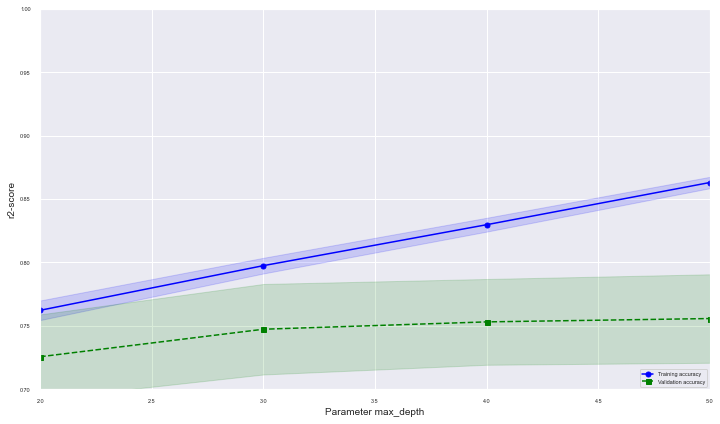

In [230]:
train_meand = np.mean(train_scoresd, axis=1)
train_stdd = np.std(train_scoresd, axis=1)
test_meand = np.mean(test_scoresd, axis=1)
test_stdd = np.std(test_scoresd, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_d, train_meand,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_d,
                 train_meand + train_stdd,
                 train_meand - train_stdd,
                 alpha=0.15, color='blue')

ax.plot(range_d, test_meand,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_d,
                 test_meand + test_stdd,
                 test_meand - test_stdd,
                 alpha=0.15, color='green')

ax.grid(b=True)
ax.set_xlabel('Parameter max_depth',fontsize=10)
ax.set_ylabel('r2-score',fontsize=10)
ax.legend(loc='lower right')
ax.set_ylim([0.7,1])
ax.set_xlim([2,5])

This time, the result is linked to the intrinsic trade off of random forest. In fact, if we increase the maximum depth of the trees the accuracy increases, because more splits are performed. But this fact brings with it the consequence that the performance is more 'linked' to that specific case, so the overfitting increases as the model suffers from high variance. Thus, here we can notice a certain difference also with a little depth, while if we increase at a certain point the validation accuracy stays the same while the training increases. This is sign that probably a good compromise is to have the depth set as 3 (in this case).

<h3>Final considerations on regression</h3>

Regression wasn't directly a subject of this course, but to me was interesting to test it on this model, as i was curious on the ML side to see how things change with a continous target.Then, also as athlete and keen on trail running i found intersting to have such powerful tools to analyze such an imprevedible sport and race. This reflects in the possibility of opening new horizons on the organization of t.r. events, as thanks to machine learning it would be possible to analyze also the security side, or also to define more accurate places for checkpoints and new time gates. Going back to the project, considering that the regression wasn't treated, so i didn't have the same preparation in it with respect to classification, the result seems to be quite satisfactory. The last thing i want to do is to see if the Model underestimated or overestimated the performance of the best athlete!

In [233]:
perf = reg_best.best_estimator_.predict(X_testr)

In [235]:
perf.sort()

In [237]:
print(perf[0])

1609.0149570041826


This is the winner of UTMB! In hours, he took 26 hours!
This is surprising, as the winner took 21, but this can be explained by the fact that the best athletes in this race are statistically <b>Outliers</b> for the model! This because the elites ones are really in low percentage with respect to the total athletes. In fact, the average finishing time is of 40 hours for UTMB.

In [238]:
avg = sum(perf)/len(perf)

In [241]:
print(avg/60)

39.73446633493368


Now, if we see that the average finishing time of the prevision is really close to 40 hour, the idea presented above gets more strong, so that the best athletes in the world are outliers, both in their sport and in statistics!
An interesing topic would be to integrate more elites performances, maybe from other editions, and see if the result changes,or to create models to prevent performances only of elites athletes, but this maybe would be the subject of other projects.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=262cdd7c-8e16-4f5f-97ff-7c655d60777a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>